# DeepLearning Predictions on Multiclass Obesity Risk dataset

<HR>

[<b>Multi-Class Prediction of Obesity Risk</b>](https://www.kaggle.com/competitions/playground-series-s4e2) dataset.
#### download dataset
<p style="color:blue; font-size:1.2em">
  If you are on Kaggle go to competition page and create a notebook<br />
  -OR- if Kaggle is setup at home, please download dataset<br />
  !kaggle competitions download -c playground-series-s4e2
</p>
<hr>

<div class="alert alert-block alert-info"><p style ="font-size:1.3em">
<h4>After multiple iterations using various data analysis and manipulation techniques:<br /><br /> 
  <u> acurracy always seems to hit the 89% ceiling and stop there.</u></h4>
</div>
<p>

**Note:** I put comments in appropriate places in Notebook my analysis, and what EDA methods I had tried. <br />
**If you are going to try out this notebook, appreciate if you can let me know what you did to improve accuracy**
</p>


<div class="alert alert-block alert-warning" style="font-size:1.2em"><b>
[Notebook on Kaggle](https://www.kaggle.com/code/jayyanamandala/DLNN_OneHot_DecisionTree_PCA_HyperTuning_Flow)
</b></div>

<div class="alert alert-block alert-info">

<b>Flow used in this notebook<br />

$$Create datasets -> EDA -> Decision Trees -> Split -> Augmentation -> PCA -> Neural Network -> Hyperparameter Search ->$$
$$-> model.fit (Train/Validation) -> model.evaluate (Validation) -> model.predict (Hold-Out)$$

<strong style="color:red;">Tried multiple ways to get Neural Networks to improve accuracy for this dataset, but could not pierce the 90% ceiling</strong>

<div class="alert alert-block alert-info">

<b>Notebook uses Keras_Tuner to search for best hyperparameter values - initial search was over `25` parameters</b><br />
Since prediction is on non-image dataset, we only use Fully-Connected Dense layers, This is a Functional Neural Network model:<br />

$$Input -> Dense -> DropOut -> BatchNormalization -> Dense -> DropOut -> Dense(output, sigmoid-activation)$$

<ul>
    <li>batch_size - same is referenced in 'HyperTuningNetwork' class but name is different</li>
    <li>number of epochs in run</li>
    <li>Number of Neurons in first fully connected Dense layer</li>
    <li>Number of Neurons in second fully connected Dense layer</li>
    <li>drop_rates - for two Dropout layers</li>
    <li>kernel_regularizers(4), bias_regularizers(4), activity_regularizers(4)</li>
    <li>layer activation - relu, tanh, sigmoid, ..
    <li>model optimizer - adam, sgd, ...</li>
    <li>learning_rate - learning_rate for Model optimizer</li>
    <li>decay_steps - - learning rate decay steps</li>
    <li>decay_rate - learning_rate decay</li>
  </ul>

</div>

<div class="alert alert-block alert-info"><h1>Description of Columns</h1></div>

ref: https://www.kaggle.com/code/kattat/ps4e2-eda-fe-pytorch
**categorical**
- Gender
- SMOKE 
- MTRANS - transportation
- CAEC - Consumption of food between meals
- SCC - Calories consumption monitoring
- CALC - Consumption of Alcohol
- FAVC - Frequency of consumption of high calorie foods
- family_history_with_overweight

**numerical**
- FCVC - Frequency of consumption of vegetables
- NCP - Number of main meals
- CH2O - Consumption of water
- FAF - Physical activity frequency
- TUE - Time using tech devices
- Age
- Height
- Weight

<div class="alert alert-block alert-info"><h1>import packages</h1></div>

In [123]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%autosave 60
import kaggle
from datetime import datetime
from tabulate import tabulate

pd.set_option('display.max_columns', None)

Autosaving every 60 seconds


In [124]:
import os
import shutil
import sys
from glob import glob
import re
import math
import random as py_random   # to differentiate btw Numpy and Python - incase random is set to np.random

In [125]:
# preprocessing and model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler 
from sklearn.decomposition import PCA

# metrics and utils
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight, compute_sample_weight
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn import set_config
set_config(display="diagram")

import scipy

In [126]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import to_categorical

In [127]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.set_visible_devices(gpus[1:],'GPU')
#     tf.config.experimental.set_memory_growth(gpus[0], True)
#     print('setting session for memory growth')
#   except:
#     pass

In [128]:
# Notebook uses PowerTransformer scaling - version of scikit-learn package must be higher than 1.2.2
# !pip install scikit-learn>1.2.2 --upgrade
import sklearn as sk
print(sk.__version__)

1.3.1


In [129]:
def reset_seeds():
   np.random.seed(42)
   py_random.seed(42)
   tf.random.set_seed(42)

# set a beginning for consistensy
reset_seeds()

<div class="alert alert-block alert-info"><h1>load datasets</h1></div>

In [130]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
train_cat_cols = train_df.select_dtypes(include=['object', 'category'])
test_cat_cols = test_df.select_dtypes(include=['object', 'category'])
train_num_cols = train_df.select_dtypes(exclude=['object', 'category'])
test_num_cols = test_df.select_dtypes(exclude=['object', 'category'])

# Drop 'id' column from Train and Test
train_num_cols.drop(['id'], inplace=True, axis=1)
test_num_cols.drop(['id'], inplace=True, axis=1)

<div class="alert alert-block alert-info"><h1>Intial Data Explortion - and cleanup</h1></div>

In [131]:
# print columns to check
pd.DataFrame(data=[train_df.columns, test_df.columns]).T.rename({0:'Train', 1:'Test'}, axis=1)

,Train,Test
0,id,id
1,Gender,Gender
2,Age,Age
3,Height,Height
4,Weight,Weight
5,family_history_with_overweight,family_history_with_overweight
6,FAVC,FAVC
7,FCVC,FCVC
8,NCP,NCP
9,CAEC,CAEC


<div class="alert alert-block alert-info"><h4>Get list of category columns from train and test datasets and check if the unique values match</h4>
 <b>do not check the 'ground truth' column</b>

</div>

In [132]:
# check unique values in Category columns - must be equal
def check_columns_exist(df1,df2, check_equal=True, traindf = train_df, testdf=test_df):
  for i in df1.columns:
    if i in df2.columns:
      try:
        if not np.array_equal( np.sort(np.unique(traindf[i])), 
                            np.sort(np.unique(testdf[i]))):
          print('\n#####Column:', i , 'elements are not equal ######')
          print('Train:', np.sort(np.unique(traindf[i])), 
              '\nTest:', np.sort(np.unique(testdf[i])), end='\n\n')
        else:
          pass
          # print('\nColumn:', i , '\nTrain:', np.sort(np.unique(traindf[i])), 
          #     '\nTest:', np.sort(np.unique(testdf[i])))
      except: 
          pass
    else:
      print('\nColumn:', i , 'does not exist in testdf', end='\n\n')

In [133]:
# check category columns in Train and Test and also check if elements in each Category are same
check_columns_exist(train_cat_cols, test_cat_cols)


#####Column: CALC elements are not equal ######
Train: ['Frequently' 'Sometimes' 'no'] 
Test: ['Always' 'Frequently' 'Sometimes' 'no']


Column: NObeyesdad does not exist in testdf



In [134]:
# get totals and percentages for each category and kind
def get_percent(col, kk, df):
  # for kk in np.sort(np.unique(df[col])):
  total = len(df[df[col] == kk])
  val = (total/len(df)) * 100
  val = f'{val:.2f}'
  val=float(val)
  return total, val


In [135]:
# Create MultiIndex DataFrame
def print_stats(df1=train_df, df2=test_df):

  # create values for train dataset
  train_totals=[]
  train_values=[]
  train_categories = []
  train_columns = []

  train_cat_cols = df1.select_dtypes(include=['object', 'category'])
  test_cat_cols = df2.select_dtypes(include=['object', 'category'])

  # check unique values in Category columns - must be equal
  for i in train_cat_cols.columns:
    if i in test_cat_cols.columns:
      kk = np.sort(np.unique(train_df[i]))
      for k in kk:
        # print(f'i:{i} - kk:{kk} - k:{k} ')
        train_columns.append(i)
        tr_total, tr_val = get_percent(i, k, train_df)
        # print(f'tr_total:{tr_total} - tr_val:{tr_val}')
        train_categories.append(k)
        train_totals.append(tr_total)
        train_values.append(tr_val)

  # create values for test dataset
  test_categories = []
  test_totals=[]
  test_values=[]

  # check unique values in Category columns - must be equal
  for i in train_cat_cols.columns:
    if i in test_cat_cols.columns:
      kk = np.sort(np.unique(test_df[i]))
      for k in kk:
        # print(f'i:{i} - kk:{kk} - k:{k} ')
        tr_total, tr_val = get_percent(i, k, test_df)
        test_categories.append(k)
        # print(f'tr_total:{tr_total} - tr_val:{tr_val}')
        test_totals.append(tr_total)
        test_values.append(tr_val)
      
  arrays_col_cats = [np.array(train_columns), np.array(train_categories)]
  arrays = list(zip(train_totals, train_values, test_totals, test_values))
  df = pd.DataFrame(arrays, columns=['Train-Totals', 'Train-Values', 'Test-Totals', 'Test-Values'])
  df.set_index(arrays_col_cats, inplace=True)
  
  diff1 = abs(df['Train-Values'] - df['Test-Values'])
  sum1 = abs(df['Train-Values'] + df['Test-Values'])
  tr_std = np.std(df['Train-Values'].astype(np.float32))
  te_std = np.std(df['Test-Values'].astype(np.float32))
  
  df['Diff %'] = round(diff1,2).astype(str) + '%'
  df['Train-Values'] = df['Train-Values'].astype(str) + '%'
  df['Test-Values'] = df['Test-Values'].astype(str) + '%'
  df['Diff/Sum'] = round(np.divide(diff1,sum1) * 100,2)
  # df['Train,Test (SD'] = f"{tr_std:.2f}, {te_std:.2f}"
  
  # cm = sns.light_palette("green", as_cmap=True)
  # df.style.background_gradient(cmap=cm)
  # df.style.text_gradient(cmap=cm)
  # print(tabulate(df, headers='keys', tablefmt='psql'))
  return df
  

In [136]:
df = print_stats()
df

Train-Totals  \
Gender                         Female                        10422   
                               Male                          10336   
family_history_with_overweight no                             3744   
                               yes                           17014   
FAVC                           no                             1776   
                               yes                           18982   
CAEC                           Always                          478   
                               Frequently                     2472   
                               Sometimes                     17529   
                               no                              279   
SMOKE                          no                            20513   
                               yes                             245   
SCC                            no                            20071   
                               yes                             687   
CALC                           Frequently                      529   
                               Sometimes                     15066   
                               no                             5163   
MTRANS                         Automobile                     3534   
                               Bike                             32   
                               Motorbike                        38   
                               Public_Transportation         16687   
                               Walking                         467   

                                                     Train-Values  \
Gender                         Female                      50.21%   
                               Male                        49.79%   
family_history_with_overweight no                          18.04%   
                               yes                         81.96%   
FAVC                           no                           8.56%   
                               yes                         91.44%   
CAEC                           Always                        2.3%   
                               Frequently                  11.91%   
                               Sometimes                   84.44%   
                               no                           1.34%   
SMOKE                          no                          98.82%   
                               yes                          1.18%   
SCC                            no                          96.69%   
                               yes                          3.31%   
CALC                           Frequently                   2.55%   
                               Sometimes                   72.58%   
                               no                          24.87%   
MTRANS                         Automobile                  17.02%   
                               Bike                         0.15%   
                               Motorbike                    0.18%   
                               Public_Transportation       80.39%   
                               Walking                      2.25%   

                                                      Test-Totals Test-Values  \
Gender                         Female                        6965      50.33%   
                               Male                          6875      49.67%   
family_history_with_overweight no                            2456      17.75%   
                               yes                          11384      82.25%   
FAVC                           no                            1257       9.08%   
                               yes                          12583      90.92%   
CAEC                           Always                         359       2.59%   
                               Frequently                    1617      11.68%   
                               Sometimes                    11689      84.46%   
                               no            

&#9888;
From the above table for categories column we can infer the following:

<ul>
<li>Four columns with binary values - Neural Networks prediction may not be optimal</li>
<li> SMOKE - 98% 'no' - data is very skewed - also not sure it affects obesity</li>
<li>SCC - Calories consumption monitoring - 97% 'no'</li>
<li>Combine MTRANS to few categories - Motors and Non_Motors</li>
<li>CALC - Consumption of Alcohol - not related to Obesity</li>
<li>CAEC - Consumption of food between meals - related to either FCVC -or- Consumption of high calorie foods</li>
<li>family_history_with_overweight - related to FCVC</li>
</ul>
**without even executing a DecisionTree analysis, we can safely drop these**

&#128308; <b>based on above table we will combine some categories in few columns'</b>

In [137]:
# update 'Bike' & 'Motobike'to 'Motors'
# update 'Public_Transportation' & 'Walking'to 'Non_Motors'
test_df['MTRANS'].replace(['Public_Transportation', 'Walking'], 'Non_Motors', inplace=True)
train_df['MTRANS'].replace(['Public_Transportation', 'Walking'], 'Non_Motors', inplace=True)

test_df['MTRANS'].replace(['Bike', 'Motorbike', 'Automobile'], 'Motors', inplace=True)
train_df['MTRANS'].replace(['Bike', 'Motorbike', 'Automobile'], 'Motors', inplace=True)

In [138]:
# extra in test dataset - merge to 'Frequently'
test_df['CALC'].replace(['Always'], 'Frequently', inplace=True)

In [139]:
# merge CAEC - 'Always' into 'Frequently'
test_df['CAEC'].replace(['Always'], 'Frequently', inplace=True)
train_df['CAEC'].replace(['Always'], 'Frequently', inplace=True)

In [140]:
df = print_stats()
# Table after combining some categories
df

Train-Totals Train-Values  \
Gender                         Female             10422       50.21%   
                               Male               10336       49.79%   
family_history_with_overweight no                  3744       18.04%   
                               yes                17014       81.96%   
FAVC                           no                  1776        8.56%   
                               yes                18982       91.44%   
CAEC                           Frequently          2950       14.21%   
                               Sometimes          17529       84.44%   
                               no                   279        1.34%   
SMOKE                          no                 20513       98.82%   
                               yes                  245        1.18%   
SCC                            no                 20071       96.69%   
                               yes                  687        3.31%   
CALC                           Frequently           529        2.55%   
                               Sometimes          15066       72.58%   
                               no                  5163       24.87%   
MTRANS                         Motors              3604       17.36%   
                               Non_Motors         17154       82.64%   

                                           Test-Totals Test-Values Diff %  \
Gender                         Female             6965      50.33%  0.12%   
                               Male               6875      49.67%  0.12%   
family_history_with_overweight no                 2456      17.75%  0.29%   
                               yes               11384      82.25%  0.29%   
FAVC                           no                 1257       9.08%  0.52%   
                               yes               12583      90.92%  0.52%   
CAEC                           Frequently         1976      14.28%  0.07%   
                               Sometimes         11689      84.46%  0.02%   
                               no                  175       1.26%  0.08%   
SMOKE                          no                13660       98.7%  0.12%   
                               yes                 180        1.3%  0.12%   
SCC                            no                13376      96.65%  0.04%   
                               yes                 464       3.35%  0.04%   
CALC                           Frequently          348       2.51%  0.04%   
                               Sometimes          9979       72.1%  0.48%   
                               no                 3513      25.38%  0.51%   
MTRANS                         Motors             2449       17.7%  0.34%   
                               Non_Motors        11391       82.3%  0.34%   

                                           Diff/Sum  
Gender                         Female          0.12  
                               Male            0.12  
family_history_with_overweight no              0.81  
                               yes             0.18  
FAVC                           no              2.95  
                               yes             0.29  
CAEC                           Frequently      0.25  
                               Sometimes       0.01  
                               no              3.08  
SMOKE                          no              0.06  
                               yes             4.84  
SCC                            no              0.02  
                               yes             0.60  
CALC                           Frequently      0.79  
                               Sometimes       0.33  
                               no              1.01  
MTRANS                         Motors          0.97  
                               Non_Motors      0.21

<div class="alert alert-block alert-info"><p style ="font-size:1.2em">Outliers Detection</p></div>

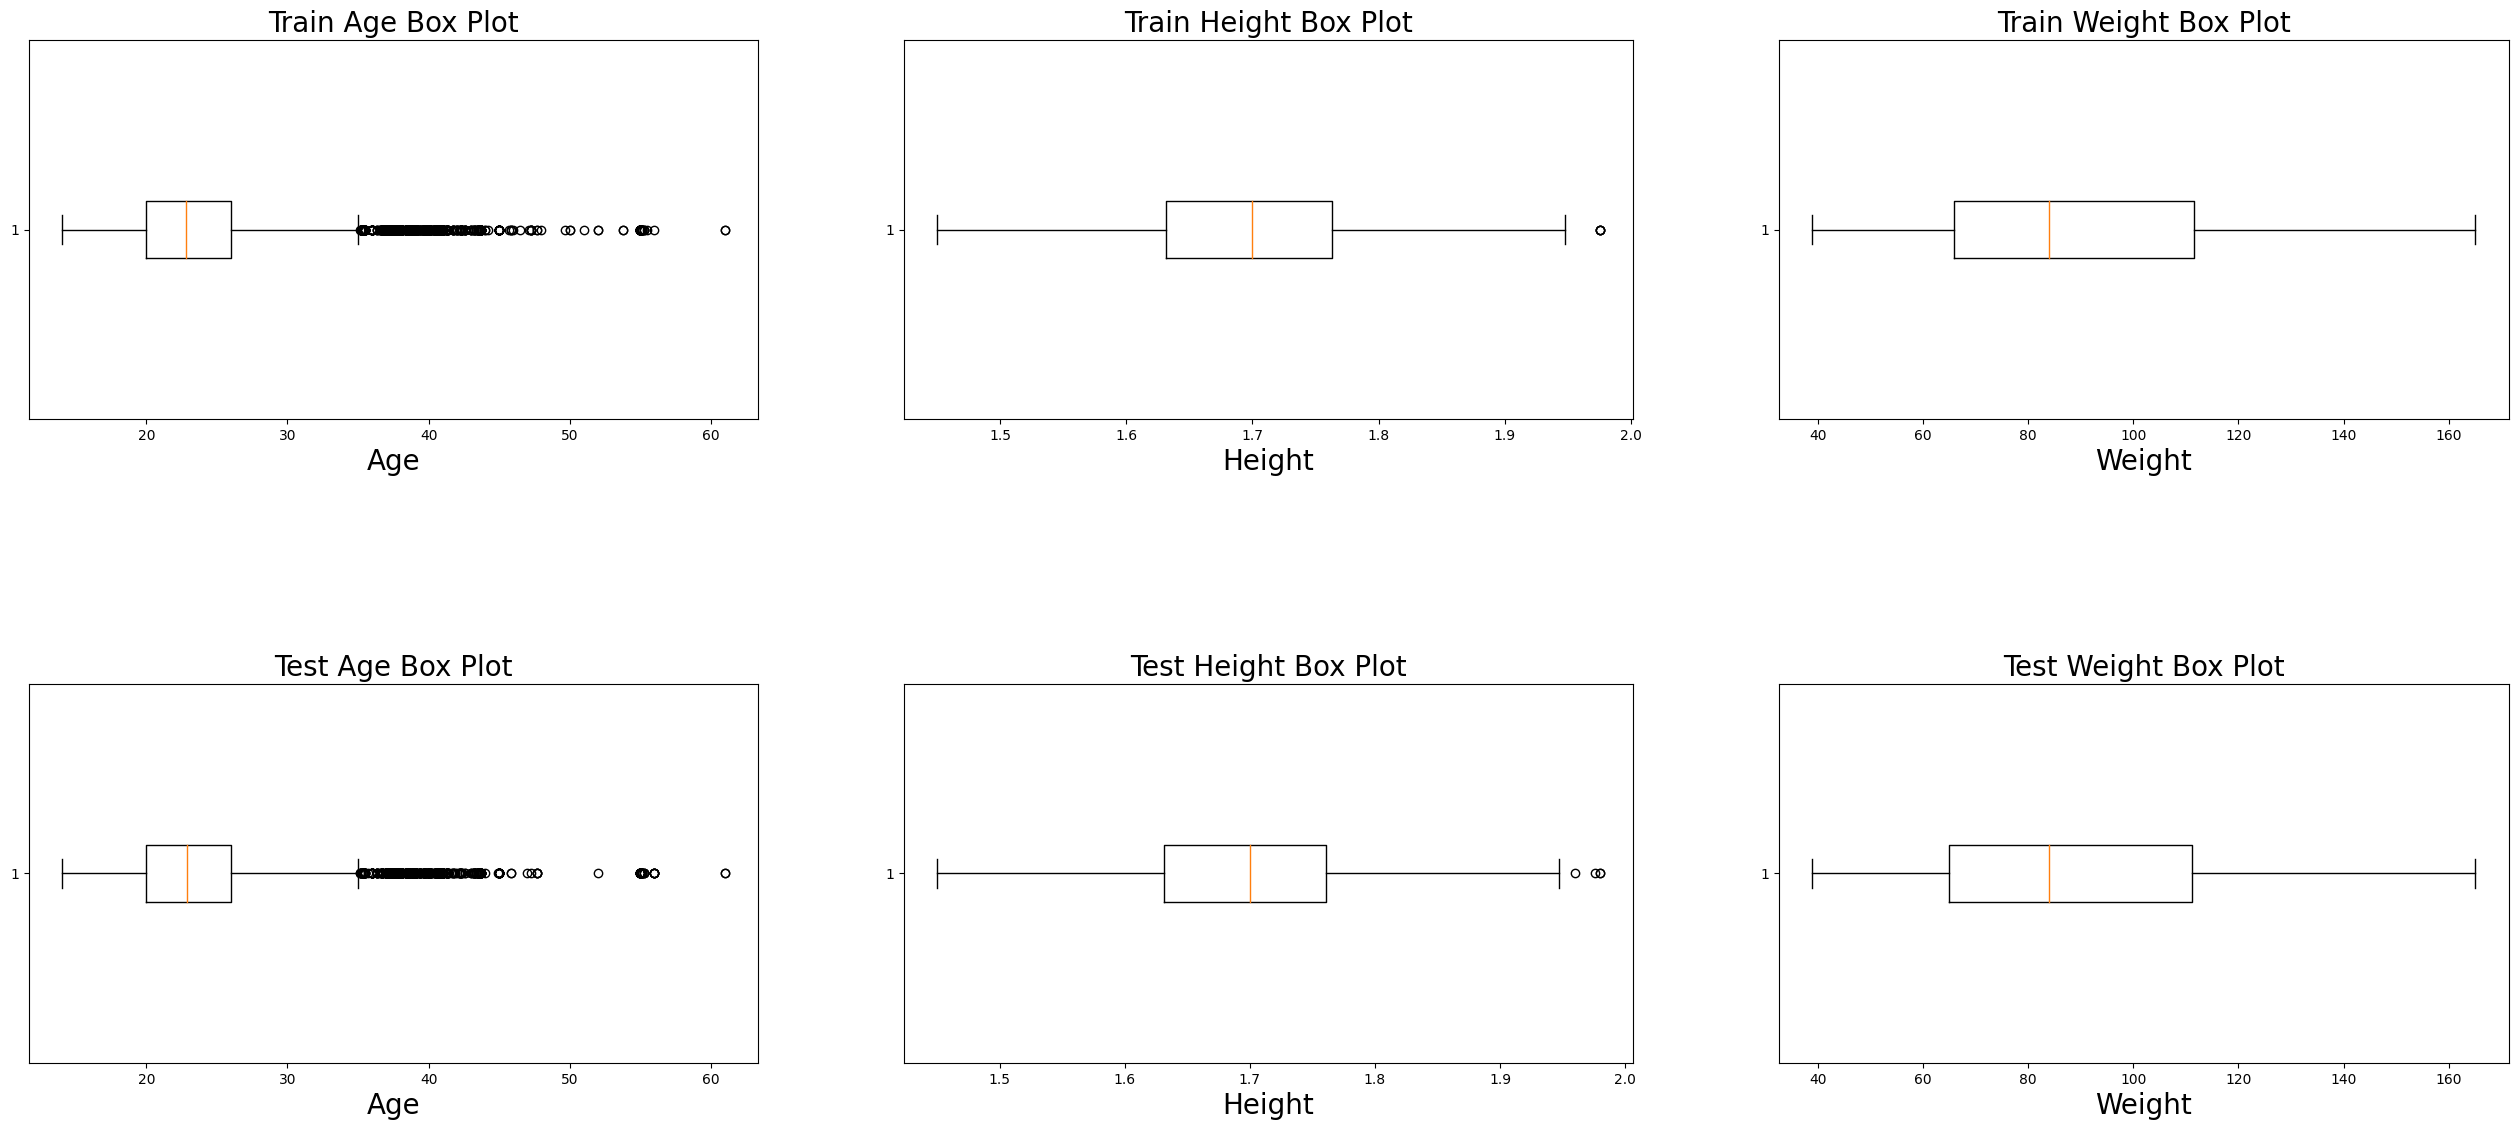

In [141]:
num_rows =  4
num_cols = 3
plt.figure(figsize=(num_rows*8,num_cols*10))

# plt.suptitle('Age/Height/Weight Box Plots')
plt.subplots_adjust(hspace=0.7)

## train dataset
plt.subplot(num_rows,num_cols,1)
plt.boxplot(train_df.Age, vert=False)
# plt.ylabel('Variable')
plt.xlabel('Age', fontdict={'fontsize':20})
plt.title('Train Age Box Plot', fontdict={'fontsize':20})

plt.subplot(num_rows,num_cols,2)
plt.boxplot(train_df.Height, vert=False)
# plt.ylabel('Variable')
plt.xlabel('Height', fontdict={'fontsize':20})
plt.title('Train Height Box Plot', fontdict={'fontsize':20})

plt.subplot(num_rows,num_cols,3)
plt.boxplot(train_df.Weight, vert=False)
# plt.ylabel('Variable')
plt.xlabel('Weight', fontdict={'fontsize':20})
plt.title('Train Weight Box Plot', fontdict={'fontsize':20})

## test dataset
plt.subplot(num_rows,num_cols,4)
plt.boxplot(test_df.Age, vert=False)
# plt.ylabel('Variable')
plt.xlabel('Age', fontdict={'fontsize':20})
plt.title('Test Age Box Plot', fontdict={'fontsize':20})

plt.subplot(num_rows,num_cols,5)
plt.boxplot(test_df.Height, vert=False)
# plt.ylabel('Variable')
plt.xlabel('Height', fontdict={'fontsize':20})
plt.title('Test Height Box Plot', fontdict={'fontsize':20})

plt.subplot(num_rows,num_cols,6)
plt.boxplot(test_df.Weight, vert=False)
# plt.ylabel('Variable')
plt.xlabel('Weight', fontdict={'fontsize':20})
plt.title('Test Weight Box Plot', fontdict={'fontsize':20})

plt.show()

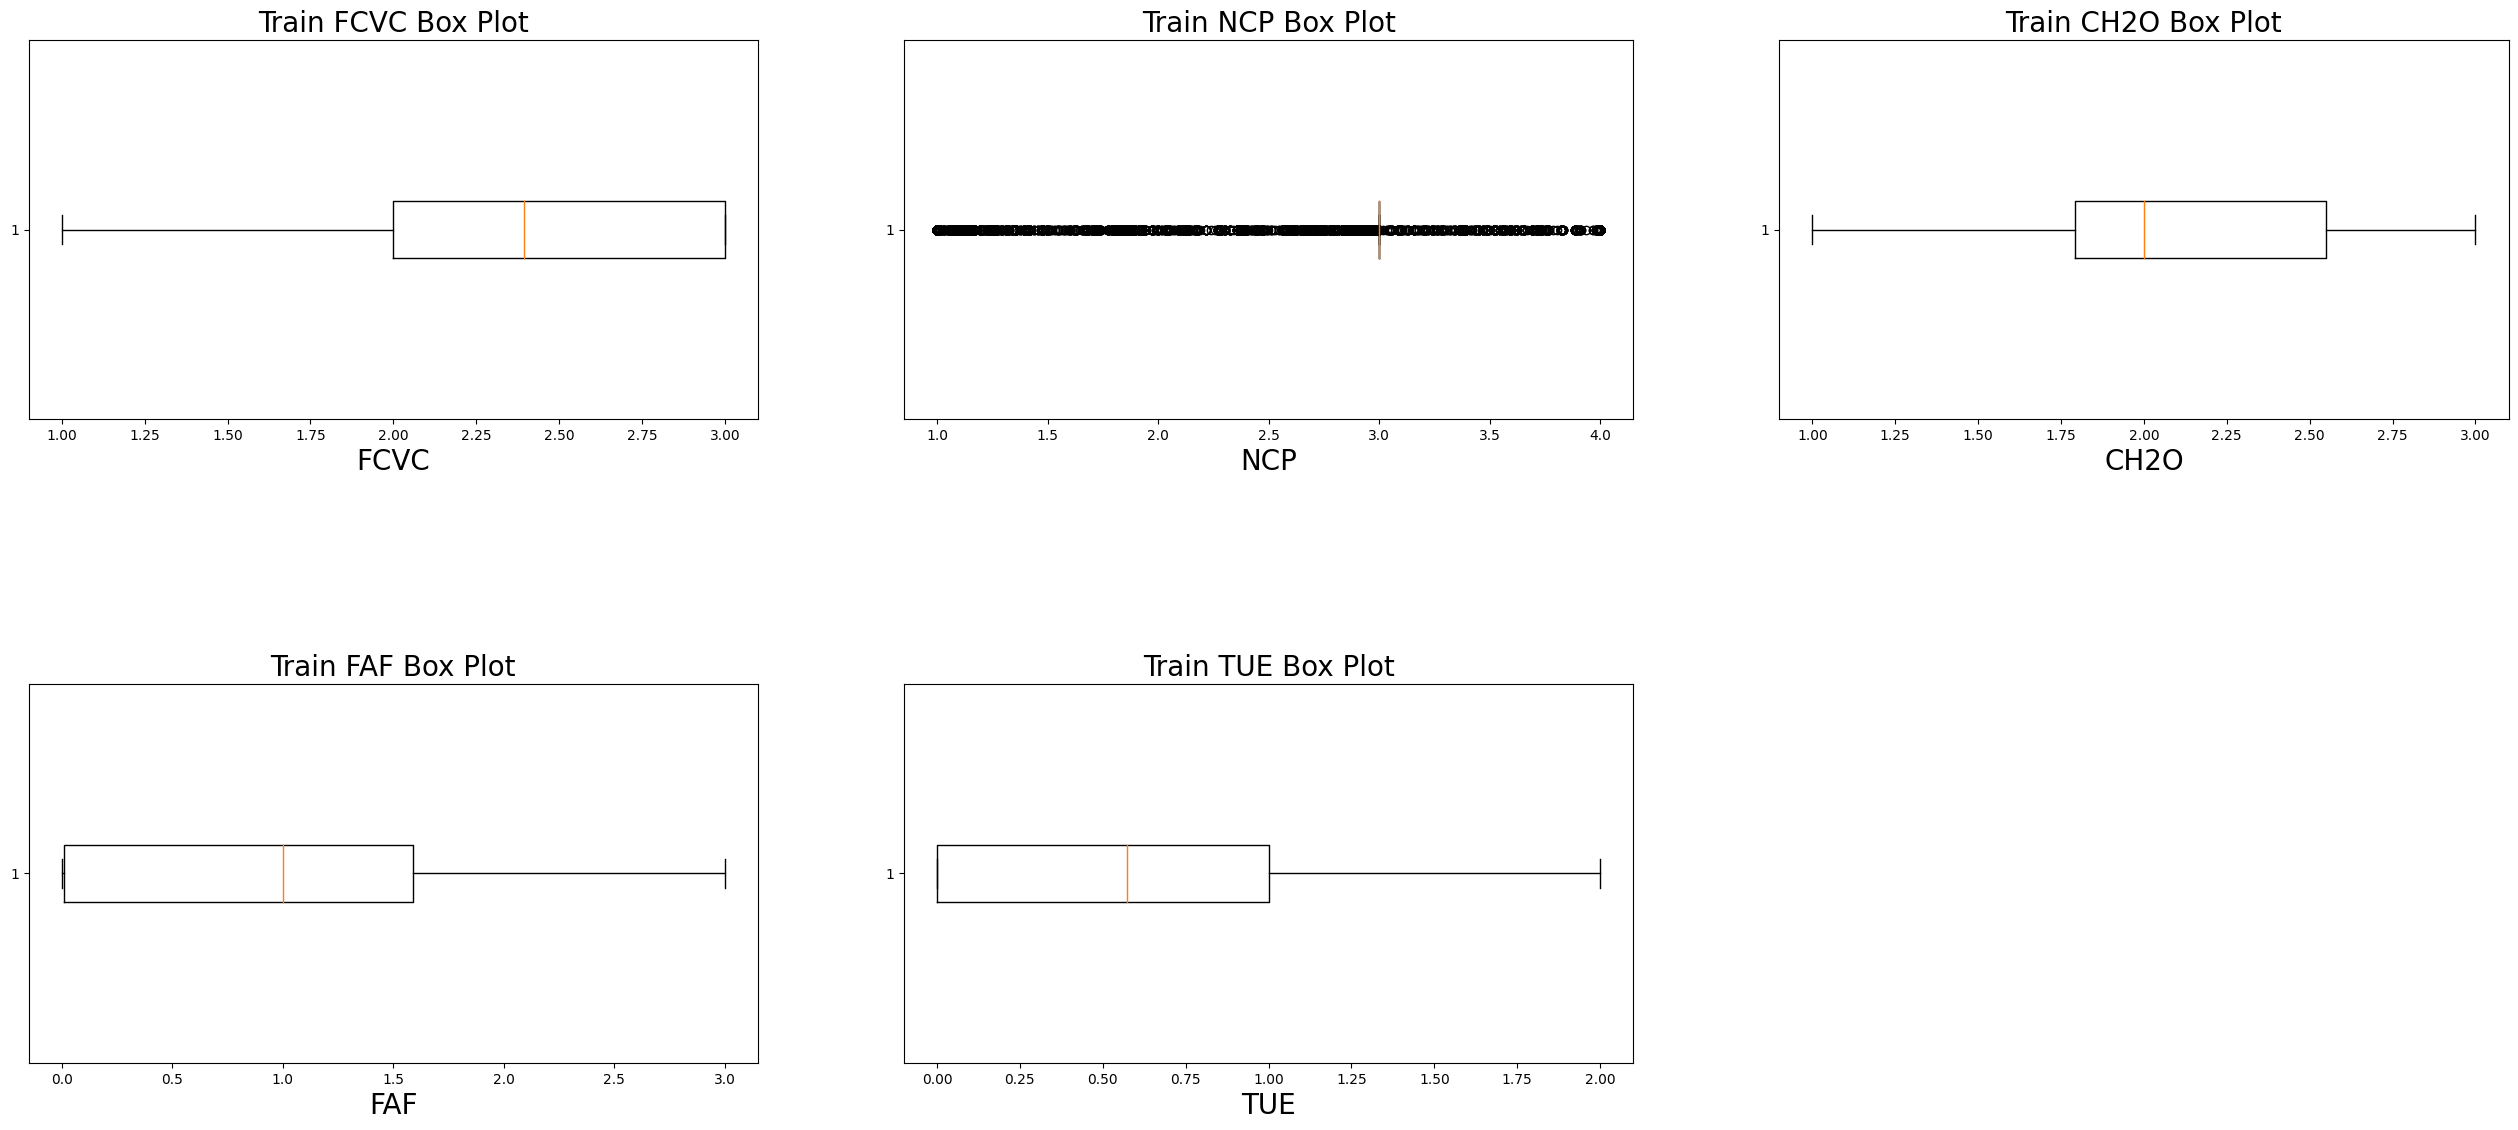

In [142]:
num_rows =  4
num_cols = 3
plt.figure(figsize=(num_rows*8,num_cols*10))

# plt.suptitle('Age/Height/Weight Box Plots')
plt.subplots_adjust(hspace=0.7)

## train dataset
plt.subplot(num_rows,num_cols,1)
plt.boxplot(train_df.FCVC, vert=False)
# plt.ylabel('Variable')
plt.xlabel('FCVC', fontdict={'fontsize':20})
plt.title('Train FCVC Box Plot', fontdict={'fontsize':20})

plt.subplot(num_rows,num_cols,2)
plt.boxplot(train_df.NCP, vert=False)
# plt.ylabel('Variable')
plt.xlabel('NCP', fontdict={'fontsize':20})
plt.title('Train NCP Box Plot', fontdict={'fontsize':20})

plt.subplot(num_rows,num_cols,3)
plt.boxplot(train_df.CH2O, vert=False)
# plt.ylabel('Variable')
plt.xlabel('CH2O', fontdict={'fontsize':20})
plt.title('Train CH2O Box Plot', fontdict={'fontsize':20})

## test dataset
plt.subplot(num_rows,num_cols,4)
plt.boxplot(train_df.FAF, vert=False)
# plt.ylabel('Variable')
plt.xlabel('FAF', fontdict={'fontsize':20})
plt.title('Train FAF Box Plot', fontdict={'fontsize':20})

plt.subplot(num_rows,num_cols,5)
plt.boxplot(train_df.TUE, vert=False)
# plt.ylabel('Variable')
plt.xlabel('TUE', fontdict={'fontsize':20})
plt.title('Train TUE Box Plot', fontdict={'fontsize':20})

plt.show()

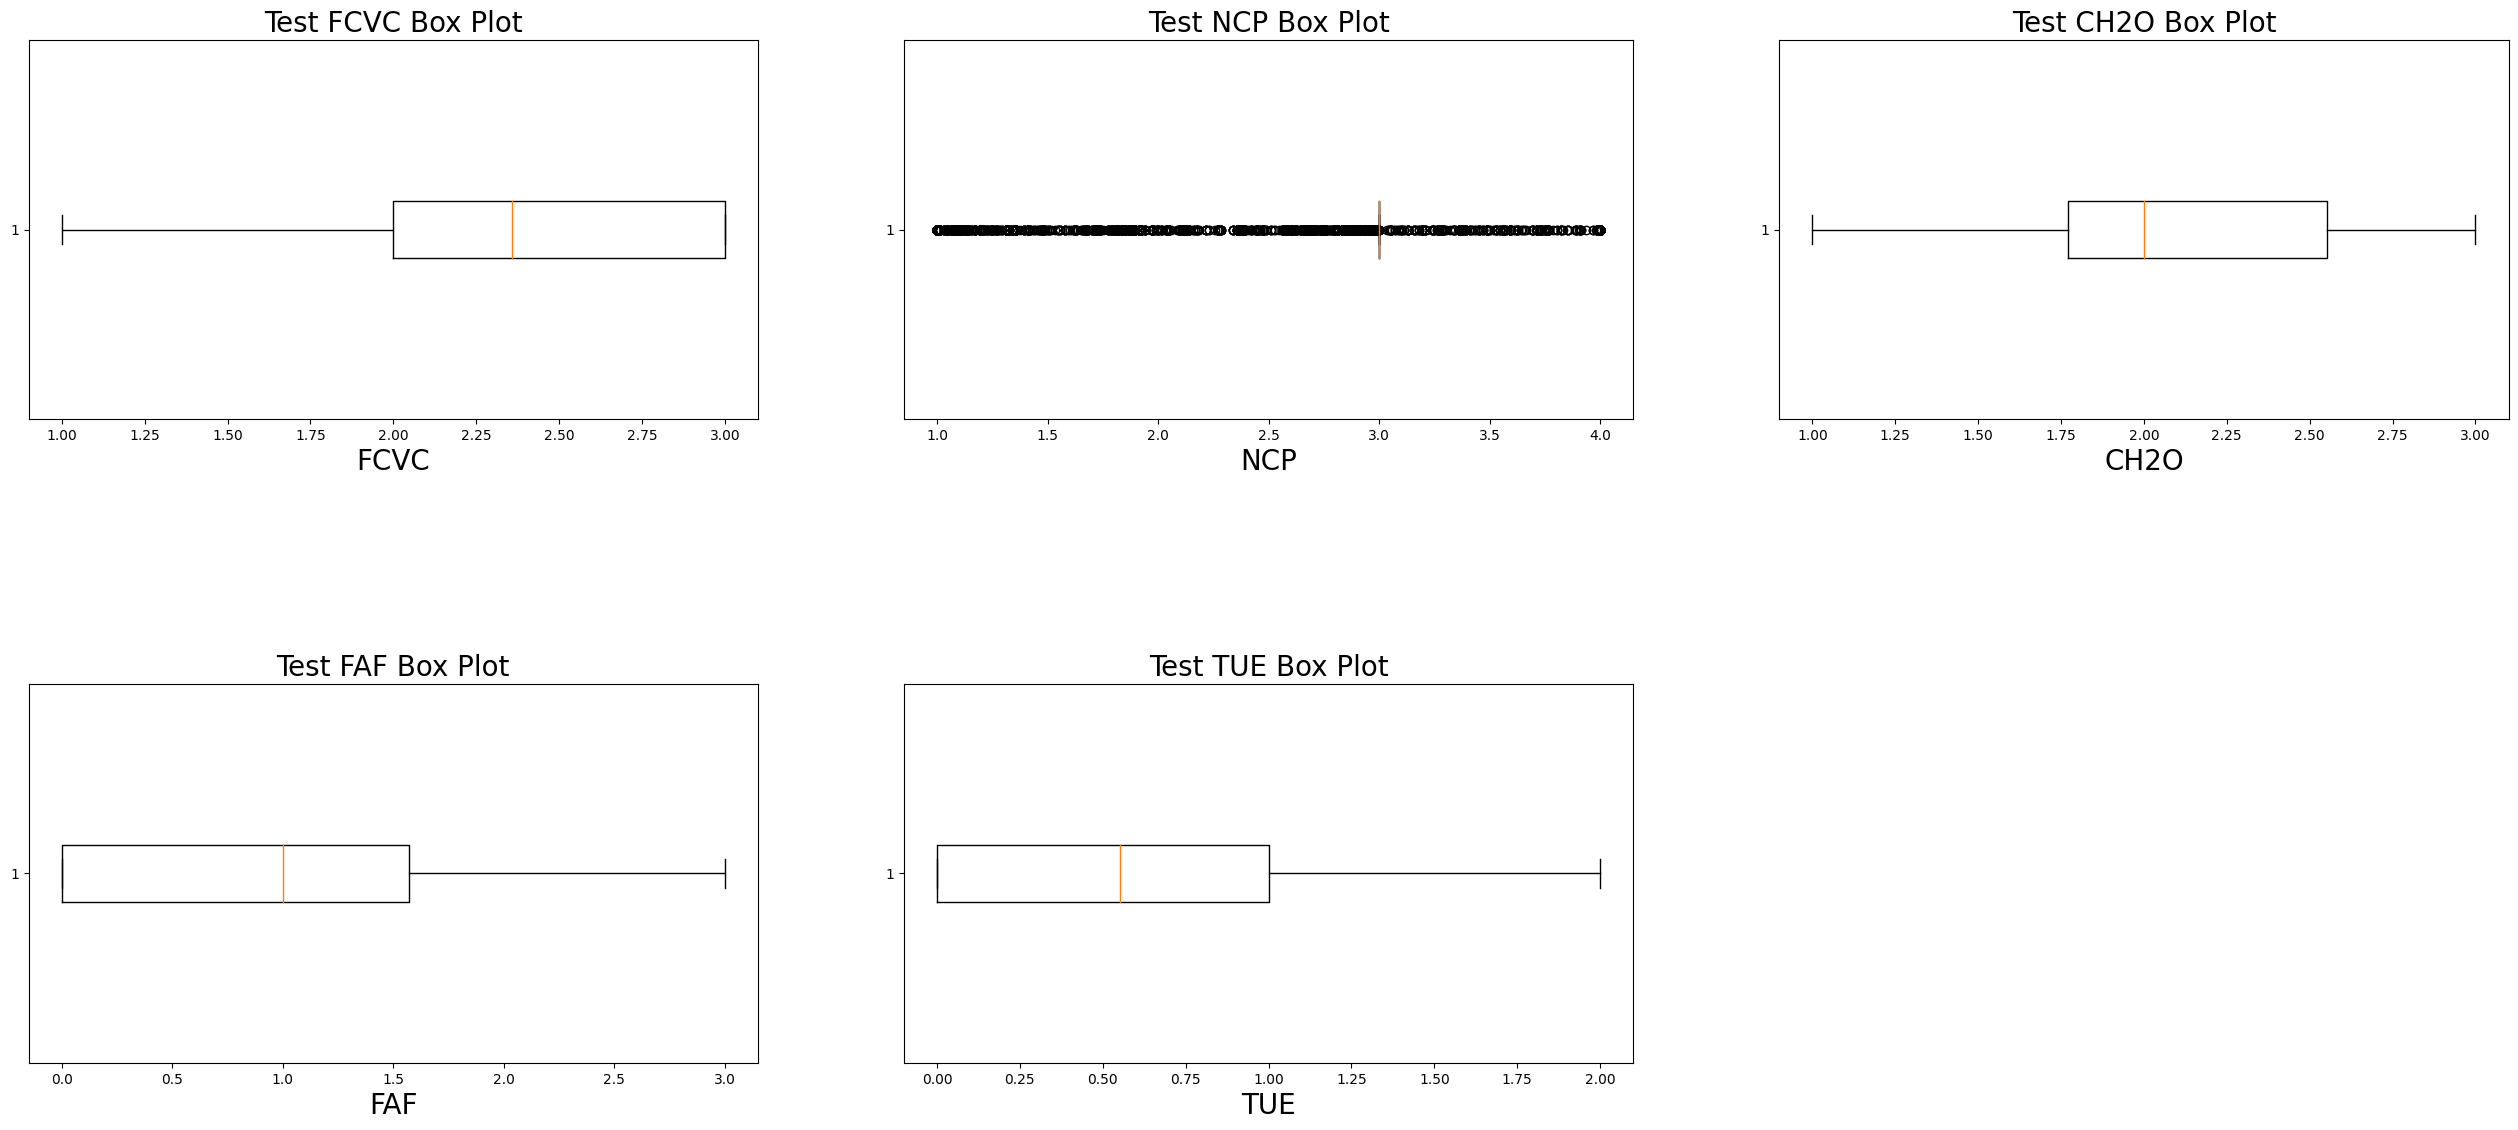

In [143]:
num_rows =  4
num_cols = 3
plt.figure(figsize=(num_rows*8,num_cols*10))

# plt.suptitle('Age/Height/Weight Box Plots')
plt.subplots_adjust(hspace=0.7)

## train dataset
plt.subplot(num_rows,num_cols,1)
plt.boxplot(test_df.FCVC, vert=False)
# plt.ylabel('Variable')
plt.xlabel('FCVC', fontdict={'fontsize':20})
plt.title('Test FCVC Box Plot', fontdict={'fontsize':20})

plt.subplot(num_rows,num_cols,2)
plt.boxplot(test_df.NCP, vert=False)
# plt.ylabel('Variable')
plt.xlabel('NCP', fontdict={'fontsize':20})
plt.title('Test NCP Box Plot', fontdict={'fontsize':20})

plt.subplot(num_rows,num_cols,3)
plt.boxplot(test_df.CH2O, vert=False)
# plt.ylabel('Variable')
plt.xlabel('CH2O', fontdict={'fontsize':20})
plt.title('Test CH2O Box Plot', fontdict={'fontsize':20})

## test dataset
plt.subplot(num_rows,num_cols,4)
plt.boxplot(test_df.FAF, vert=False)
# plt.ylabel('Variable')
plt.xlabel('FAF', fontdict={'fontsize':20})
plt.title('Test FAF Box Plot', fontdict={'fontsize':20})

plt.subplot(num_rows,num_cols,5)
plt.boxplot(test_df.TUE, vert=False)
# plt.ylabel('Variable')
plt.xlabel('TUE', fontdict={'fontsize':20})
plt.title('Test TUE Box Plot', fontdict={'fontsize':20})

plt.show()

<div class="alert alert-block alert-warning"><h4>from the above stats we can see that the datasets 'Train' and 'Test' are spread approximately equally amongst individual categorical features</h4>

As mentioned earlier we can drop these three and few others as well:
1. SMOKE 
2. SCC
3. CALC

</div>

<div class="alert alert-block alert-info"><h4>BMI column from Height and Weight</h4>

In most people, BMI correlates to<b>
[body fat](https://my.clevelandclinic.org/health/body/24052-adipose-tissue-body-fat) </b>
- the higher the number, the more body fat you but according to some clinical studies it’s not accurate in some cases.

From the train and test dataset we can infer that the weight is in 'pounds' and height is in feet   
we convert height to inches and calculate BMI

&#128165; combined Height and Weight to create BMI, but not helpful due to spread of Height over two ranges

In [144]:
# not implemented in this run
def calc_bmi(x,y): 

    # Assuming Height is in Meters and Weight in 'pounds'
    # USC - ONE -of- x in lbs, and y in inches
    # x = x * 703;  y = np.square(y); x/y

    # SI -ONE- of - x in kgs, and y in meters
    # x = x;  y = np.square(y); x/y

    # convert to inches - since weight is in pounds
    # convert height from meters first to Centimeters 
    # and multiply by 0.394 to convert to inches
    # calculate BMI and return value
    return (x * 703 )/np.square(y * 100 * 0.394)

In [145]:
# not adding new columns and dropping old ones
def not_run1():
  ## create BMI columns for train and test datasets - and drop 'Age' 'Height'
  train_df['BMI'] = train_df.apply(lambda x: calc_bmi(x['Weight'], x['Height']), axis=1)
  test_df['BMI'] = test_df.apply(lambda x: calc_bmi(x['Weight'], x['Height']), axis=1)
  
  # ## drop columns 'Weight' and 'Height' from both train_df and test_df create_datasets
  train_df.drop(['Weight', 'Height'], axis=1, inplace=True)
  test_df.drop(['Weight', 'Height'], axis=1, inplace=True)

In [146]:
# since BMI is not created turning off this plot
def no_plot1():
  num_rows =  2
  num_cols = 2
  plt.figure(figsize=(num_rows*10,4))
  
  plt.suptitle('Age/BMI Box Plots')
  plt.subplots_adjust(hspace=0.7)
  plt.subplot(num_rows,num_cols,1)
  plt.boxplot(train_df.Age, vert=False)
  plt.ylabel('Variable')
  plt.xlabel('Age')
  plt.title('Train Age Box Plot')
  
  plt.subplot(num_rows,num_cols,2)
  plt.boxplot(train_df.BMI, vert=False)
  plt.ylabel('Variable')
  plt.xlabel('BMI')
  plt.title('Train BMI Box Plot')
  
  plt.subplot(num_rows,num_cols,3)
  plt.boxplot(test_df.Age, vert=False)
  plt.ylabel('Variable')
  plt.xlabel('Age')
  plt.title('Test Age Box Plot')
  
  plt.subplot(num_rows,num_cols,4)
  plt.boxplot(test_df.BMI, vert=False)
  plt.ylabel('Variable')
  plt.xlabel('BMI')
  plt.title('Test BMI Box Plot')
  
  plt.show()

In [147]:
# not replacing since combining not helping in accuracy improvement - DecisionTree also points out the same
def no_combine1():
  test_df['MTRANS'].replace(['Public_Transportation', 'Walking'], 'Non_Motors', inplace=True)
  train_df['MTRANS'].replace(['Public_Transportation', 'Walking'], 'Non_Motors', inplace=True)
  
  test_df['MTRANS'].replace(['Bike', 'Motorbike'], 'Two_Wheelers', inplace=True)
  train_df['MTRANS'].replace(['Bike', 'Motorbike'], 'Two_Wheelers', inplace=True)

In [148]:
# let's recreate columns and numerals lists
train_cat_cols = train_df.select_dtypes(include=['object', 'category'])
test_cat_cols = test_df.select_dtypes(include=['object', 'category'])
train_num_cols = train_df.select_dtypes(exclude=['object', 'category'])
test_num_cols = test_df.select_dtypes(exclude=['object', 'category'])

In [149]:
test_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Non_Motors
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Non_Motors
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Non_Motors
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Non_Motors
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Non_Motors


In [150]:
train_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Non_Motors,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Motors,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Non_Motors,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Non_Motors,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Non_Motors,Overweight_Level_II


<div class="alert alert-block alert-info"><h4>check duplicates and NAs in train and test datasets</h4></div>

In [151]:
# ref: https://www.kaggle.com/code/nnjjpp/pipelines-for-preprocessing-a-tutorial
train_df.duplicated().sum()
pd.DataFrame([train_df.duplicated().sum(), 
           test_df.duplicated().sum()]).T.rename({0:'Train', 
                                                  1:'Test'}, 
                                                 axis=1).rename(index={0: '# of Duplicates'})

,Train,Test
# of Duplicates,0,0


In [152]:
# check NA values
pd.concat([train_df.isna().sum(0), 
           test_df.isna().sum(0)], 
          axis=1).T.rename(index={0:'Train', 
                          1:'Test'})

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
Train,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Test,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [153]:
# print columns
pd.DataFrame([train_cat_cols.columns, test_cat_cols.columns, 
              train_num_cols.columns, test_num_cols.columns, 
             ]).T.rename({0:'Train Cat', 1:'Test Cat', 2:'Train Num', 3:'Test Num'}, axis=1)

,Train Cat,Test Cat,Train Num,Test Num
0,Gender,Gender,id,id
1,family_history_with_overweight,family_history_with_overweight,Age,Age
2,FAVC,FAVC,Height,Height
3,CAEC,CAEC,Weight,Weight
4,SMOKE,SMOKE,FCVC,FCVC
5,SCC,SCC,NCP,NCP
6,CALC,CALC,CH2O,CH2O
7,MTRANS,MTRANS,FAF,FAF
8,NObeyesdad,None,TUE,TUE


From the above boxplots for 'Age' we can see that the spread for Test and Train datasets seems similar.<br>
**we will look into 'Age' later**

In [154]:
## create a new dataframe to show boxplots between numerals and:
## family_history_with_overweight
## SMOKE
## Gender
train_gender_df = pd.concat([train_df[train_num_cols.columns],  
                             train_df['Gender'].to_frame(),
                             train_df['family_history_with_overweight'].to_frame(),
                             train_df['SMOKE'].to_frame(),
                            ], 
                            axis=1)

In [155]:
## NO BMI COLUMN TO PLOT
# num_rows=1
# plt.figure(figsize=(num_rows*14,4))
# plt.suptitle('Age/BMI against family_history_with_overweight Box Plots')
# plt.subplots_adjust(hspace=0.7)
# plt.subplot(num_rows,2,1)
# sns.boxplot( x="Age", y='family_history_with_overweight', data=train_gender_df, )
# plt.subplot(num_rows,2,2)
# sns.boxplot( x="BMI", y='family_history_with_overweight', data=train_gender_df, )
# plt.show()

form the above boxplot we see that we have a lot of data of young people with no family_history_with_overweight
- data is not distributed between yes & no for Age
- <b><p style ="color:red; font-size:1.2em">cutting 'Age' into bins also was not help in this dataset generalization</p></b>

In [156]:
train_gender_df = pd.concat([train_df[train_num_cols.columns],  
                             train_df['Gender'].to_frame(),
                             train_df['family_history_with_overweight'].to_frame(),
                             train_df['SMOKE'].to_frame(),
                            ], 
                            axis=1)

In [157]:
# NO BMI COLUMN TO PLOT
# num_rows=3
# plt.figure(figsize=(num_rows*12,25))
# plt.suptitle('Age/BMI against family_history_with_overweight/SMOKE/Gender Box Plots')
# plt.subplots_adjust(hspace=0.7)
# plt.subplot(num_rows,2,1)
# sns.boxplot( x="Age", y='family_history_with_overweight', data=train_gender_df, )
# plt.subplot(num_rows,2,2)
# sns.boxplot( x="BMI", y='family_history_with_overweight', data=train_gender_df, )

# plt.subplot(num_rows,2,3)
# sns.boxplot( x="Age", y='SMOKE', data=train_gender_df, )
# plt.subplot(num_rows,2,4)
# sns.boxplot( x="BMI", y='SMOKE', data=train_gender_df, )

# plt.subplot(num_rows,2,5)
# sns.boxplot( x="Age", y='Gender', data=train_gender_df, )
# plt.subplot(num_rows,2,6)
# sns.boxplot( x="BMI", y='Gender', data=train_gender_df, )

# plt.show()

<Figure size 300x300 with 0 Axes>

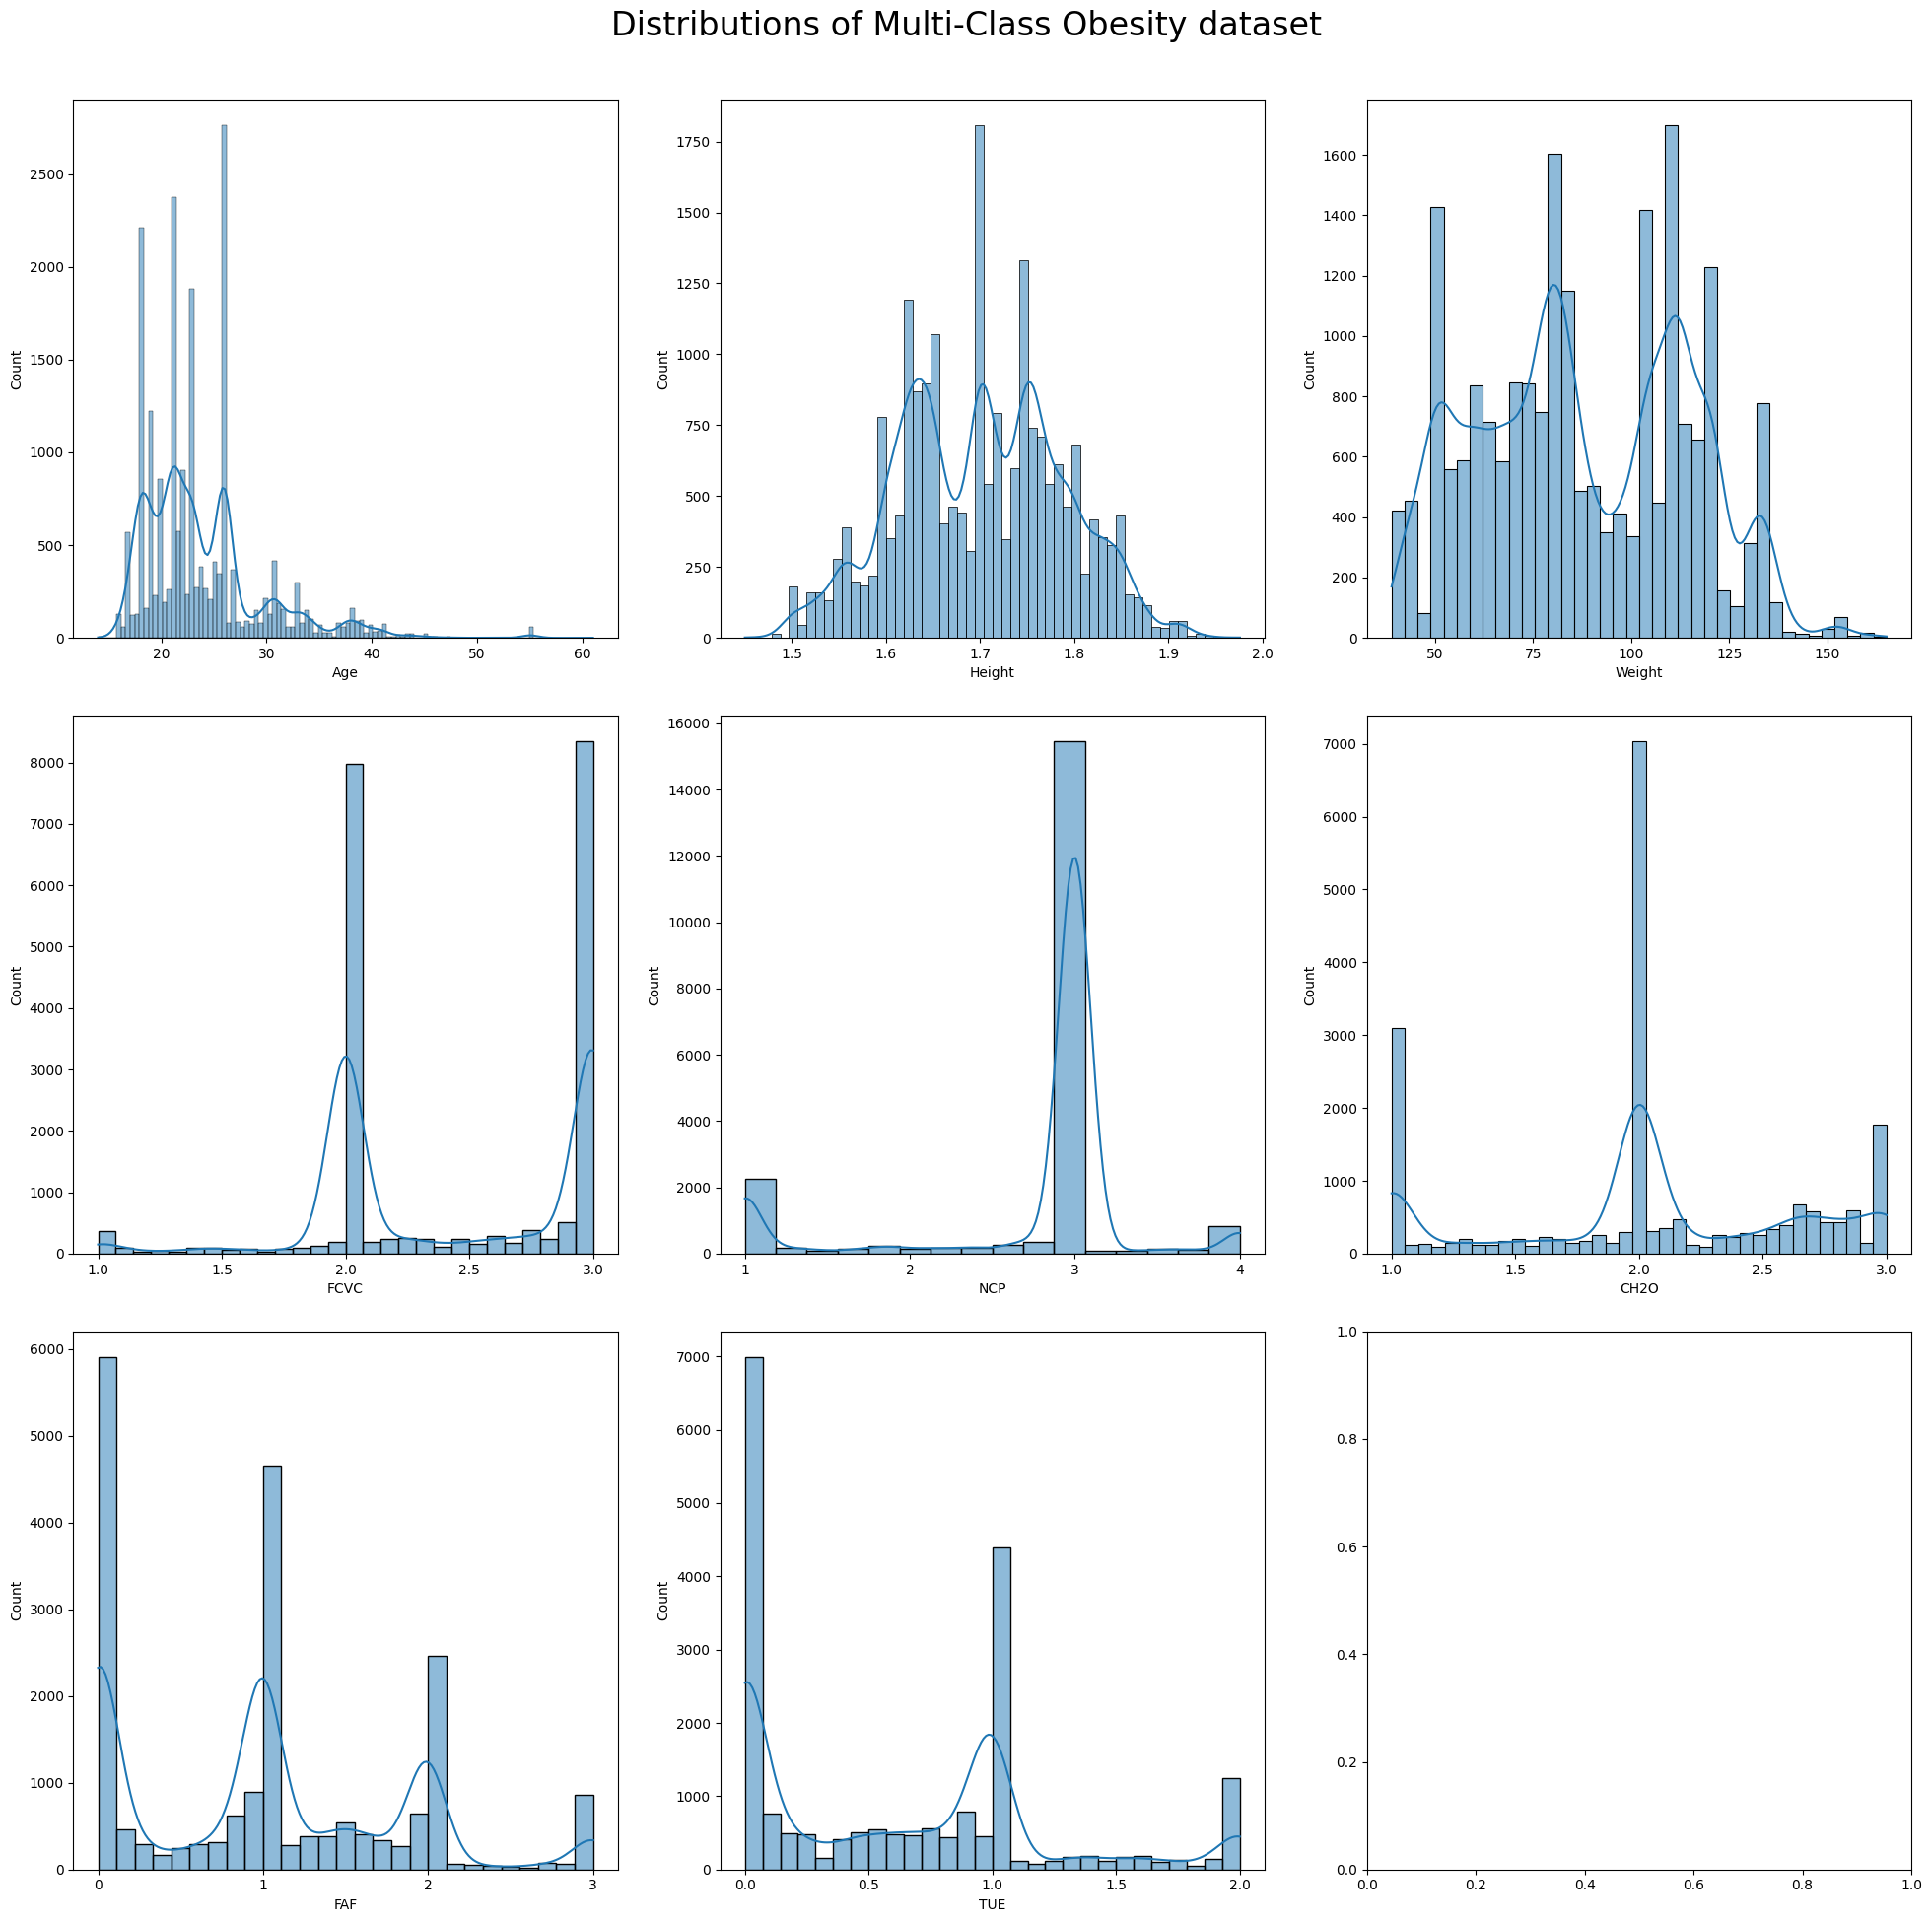

In [158]:
# Plot all features
plt.figure(figsize=(3,3))
plt.subplots_adjust(hspace=0.4)
cols = 3
rows=3
fig,ax = plt.subplots(nrows=rows,ncols=cols,figsize=(20,20))
ax = ax.flatten()
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["font.size"] = 20
truth_label='NObeyesdad'
plt.suptitle("Distributions of Multi-Class Obesity dataset\n",size=24)
# textprops={'fontsize': 16},
xx = 0
for i,col in enumerate(train_df.columns):
    if col not in train_cat_cols.columns:
      # print('1',col)
      if col == 'id':    # do not plot 'id'column
        continue
      else:
        sns.histplot(data=train_df,x=col,ax=ax[xx],kde=True,line_kws={"ls":"-"})
        xx += 1

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info"><p style ="font-size:1.2em">Bin Age convert to  categories</p></div>
<strong>We use same bins for Training and Test datasets</strong>

In [159]:
#########################                                                                                           
# ref: https://stackoverflow.com/questions/45751390/pandas-how-to-use-pd-cut
#########################                                                                                           
def scale_bins(nbins, trainx, testx, col):
                                                                                                                        
  num_bins = nbins                                                                                                    
  col_bins = col+'_bins'                                                                                              
  col1 = ((trainx[col]//num_bins)*num_bins).min()                                                                     
  col2 = ((trainx[col]//num_bins+1)*num_bins).max()                                                                   
  print(col,': ', trainx[col].min(), trainx[col].max(), trainx[col].nunique())                                        
  split1 = float(col1 + num_bins)                                                                                     
  split2 = float(col2 + num_bins)                                                                                                                                                                                                         
  # age_bins = np.arange(age1,age2+num_bins,num_bins)                                                                
  colsplit   = np.arange(split1,split2,num_bins)                                                                      
  carr = np.array(colsplit)                                                                                                                                                                                                               
  # q_col_bins = [f'{int(i)}-{int(j)}' for i, j in zip(col_bins[:-1], col_bins[1:])]                                  
  # col_labels = ['col_'+str(round(f)) for f in np.arange(col1,col2+num_bins,num_bins)]                               
  print('col_bins:', carr)                                                                                                                                                                                                                
  trainx[col_bins] = carr.searchsorted(trainx[col],side='right')                                                      
  testx[col_bins] = carr.searchsorted(testx[col],side='right')                                                        
  print(trainx.loc[:,[col, col_bins]].head())                                                                                                                                                                                             
  testx.drop([col], axis=1, inplace=True)                                                                             
  trainx.drop([col], axis=1, inplace=True)


In [160]:
### Age 
# scale_bins(1, train_df, test_df, 'Age')

### BMI
### scale_bins(3, train_df, test_df, 'BMI') 
## train_df.drop(['Weight','Height'], axis=1, inplace=True)
## test_df.drop(['Weight','Height'], axis=1, inplace=True)
# scale_bins(5, train_df, test_df, 'Weight')
## scale_bins(0.4, train_df, test_df, 'Height')  - we drop Height

In [161]:
# categorical
train_cat_cols = train_df.select_dtypes(include=['object', 'category'])
test_cat_cols = test_df.select_dtypes(include=['object', 'category'])

# numerical
train_num_cols = train_df.select_dtypes(exclude=['object', 'category'])
test_num_cols = test_df.select_dtypes(exclude=['object', 'category'])

In [162]:
train_df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Non_Motors,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Motors,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Non_Motors,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Non_Motors,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Non_Motors,Overweight_Level_II


In [163]:
print(tabulate(pd.DataFrame(train_df.nunique().to_frame())[1:], headers='keys', tablefmt='psql'))

+--------------------------------+------+
|                                |    0 |
|--------------------------------+------|
| Gender                         |    2 |
| Age                            | 1703 |
| Height                         | 1833 |
| Weight                         | 1979 |
| family_history_with_overweight |    2 |
| FAVC                           |    2 |
| FCVC                           |  934 |
| NCP                            |  689 |
| CAEC                           |    3 |
| SMOKE                          |    2 |
| CH2O                           | 1506 |
| SCC                            |    2 |
| FAF                            | 1360 |
| TUE                            | 1297 |
| CALC                           |    3 |
| MTRANS                         |    2 |
| NObeyesdad                     |    7 |
+--------------------------------+------+


In [164]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

<div class="alert alert-block alert-info"><h4>function to split trainXY and test_X</h4></div>

&#128308;<b>In the function earlier was dropping columns - instead imit `PCA` to few components</b>

In [165]:
def create_datasets(trainx, testx):

  # numeric columns:  ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
  # categorical columns:['Gender', 'family_history_with_overweight',
  #                       'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC',
  #                       'MTRANS', 'NObeyesdad']
  #
  # split train_XY into train_X and train_Y (ground truth labesl)
  # capture test_ids
  submit_id = testx['id']
  
  # split train_XY into train_X and train_Y (ground truth labesl)
  trainy = trainx['NObeyesdad']
  testx = testx.drop(['id'], axis=1)
  trainx = trainx.drop(['id','NObeyesdad'], axis=1)

  ## Remove few columns from dataseta
  # testx = testx.drop(['family_history_with_overweight', 'SMOKE','SCC','MTRANS',
  #                    'NCP', 'FCVC','TUE','CALC','CH2O','CAEC'], axis=1)
  # trainx = trainx.drop(['family_history_with_overweight', 'SMOKE','SCC','MTRANS',
  #                      'NCP','FCVC','TUE','CALC','CH2O','CAEC'], axis=1)

  return trainx, trainy, testx, submit_id

#######################
# create training sets train_X, train_Y, test_X, test_id 
train_X, train_Y,  test_X, test_id = create_datasets(train_df, test_df)

In [166]:
# check NA values
check_na = pd.concat([train_X.isna().sum(0), 
           test_X.isna().sum(0)], 
          axis=1).T.rename(index={0:'Train', 
                          1:'Test'})

print(tabulate(check_na.T, headers='keys', tablefmt='psql'))

+--------------------------------+---------+--------+
|                                |   Train |   Test |
|--------------------------------+---------+--------|
| Gender                         |       0 |      0 |
| Age                            |       0 |      0 |
| Height                         |       0 |      0 |
| Weight                         |       0 |      0 |
| family_history_with_overweight |       0 |      0 |
| FAVC                           |       0 |      0 |
| FCVC                           |       0 |      0 |
| NCP                            |       0 |      0 |
| CAEC                           |       0 |      0 |
| SMOKE                          |       0 |      0 |
| CH2O                           |       0 |      0 |
| SCC                            |       0 |      0 |
| FAF                            |       0 |      0 |
| TUE                            |       0 |      0 |
| CALC                           |       0 |      0 |
| MTRANS                    

In [167]:
# recapture columns list - category, and numerical
# categorical
train_cat_cols = train_X.select_dtypes(include=['object', 'category'])
test_cat_cols = test_X.select_dtypes(include=['object', 'category'])

# numerical
train_num_cols = train_X.select_dtypes(exclude=['object', 'category'])
test_num_cols = test_X.select_dtypes(exclude=['object', 'category'])

# show numerical columns
pd.DataFrame([train_num_cols.columns, test_num_cols.columns]).rename(index={0:'Train', 1:'Test'})

,0,1,2,3,4,5,6,7
Train,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Test,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE


In [168]:
# show categorical columns
pd.DataFrame([train_cat_cols.columns, test_cat_cols.columns]).rename(index={0:'Train', 1:'Test'})

,0,1,2,3,4,5,6,7
Train,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
Test,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS


<div class="alert alert-block alert-info"><h1>plot categorical columns</h1></div>

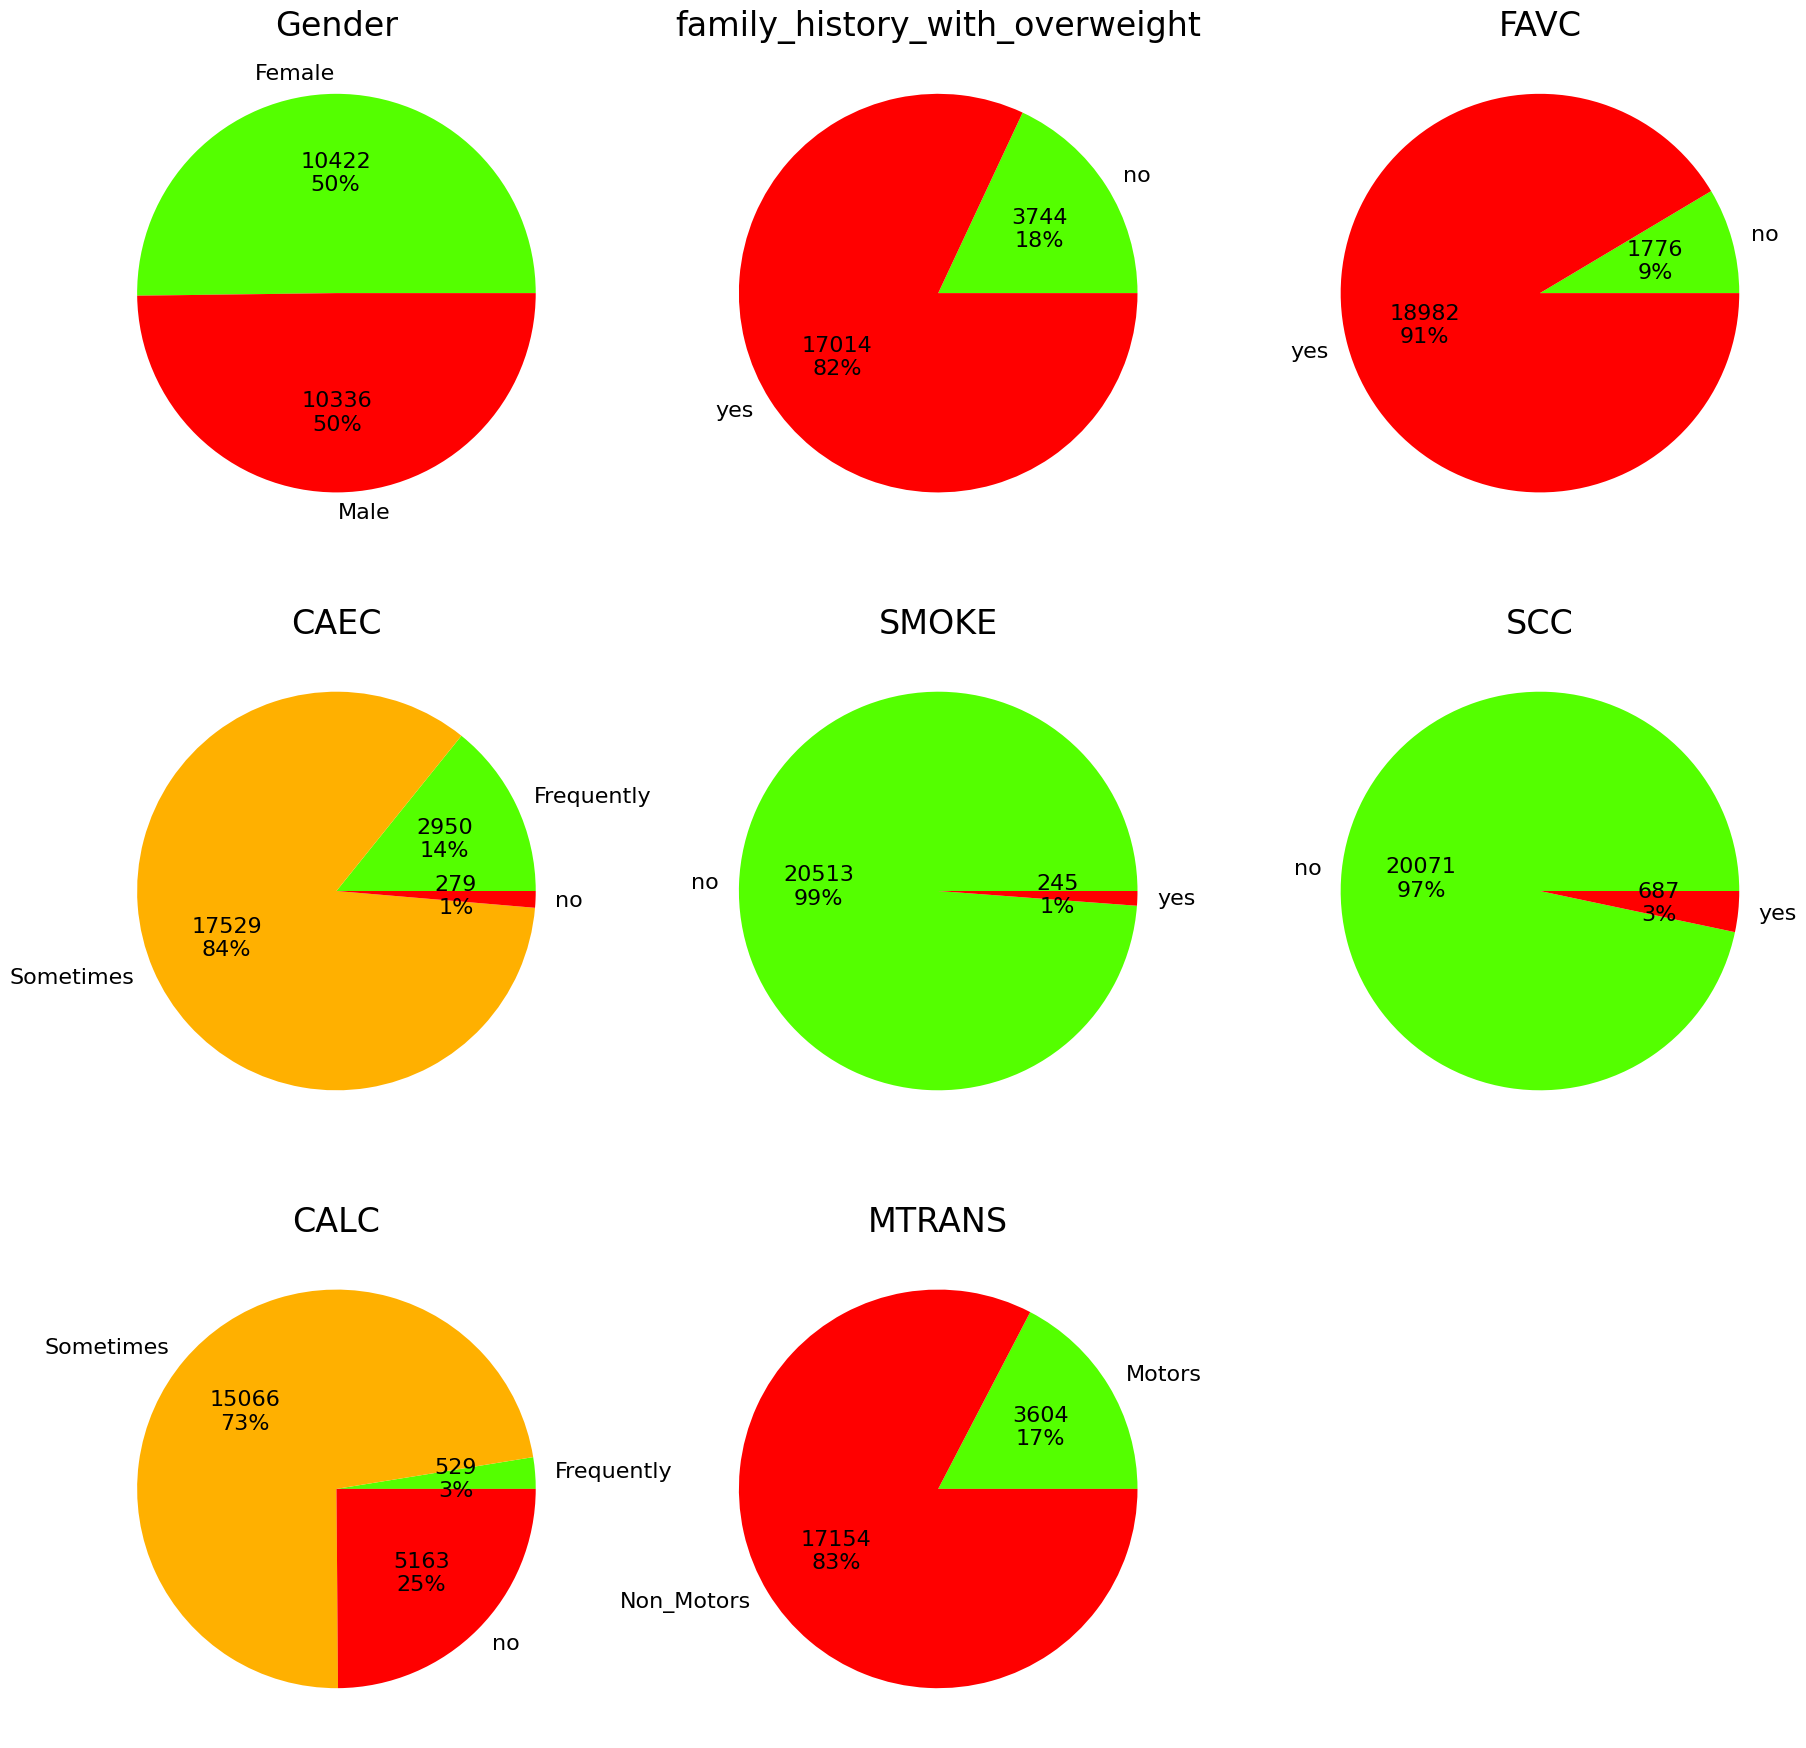

In [169]:
plt.figure(figsize=(22,22))
plt.rcParams["axes.labelsize"] = 20
rows, num = 3, 3
cols = 0

# ref: https://stackoverflow.com/questions/63687789/how-do-i-create-a-pie-chart-using-categorical-data-in-matplotlib
def label_function(val):
  return f'{val / 100 * len(train_cat_cols):.0f}\n{val:.0f}%'   # returns nums and percent
  # return f'{val:.0f}%'

for n in range(rows):
  for i in range(num):
    plt.subplot(3,3,cols+1)
    if len(test_cat_cols.columns) > cols:
      train_cat_cols.groupby(train_cat_cols.columns[cols]).size().plot(kind='pie', 
                                                                     autopct=label_function, 
                                                                     textprops={'fontsize': 16},
                                                                     colormap='prism_r'
                                                                    )
      plt.title(train_cat_cols.columns[cols])
    cols += 1
    plt.axis('off')
  
  

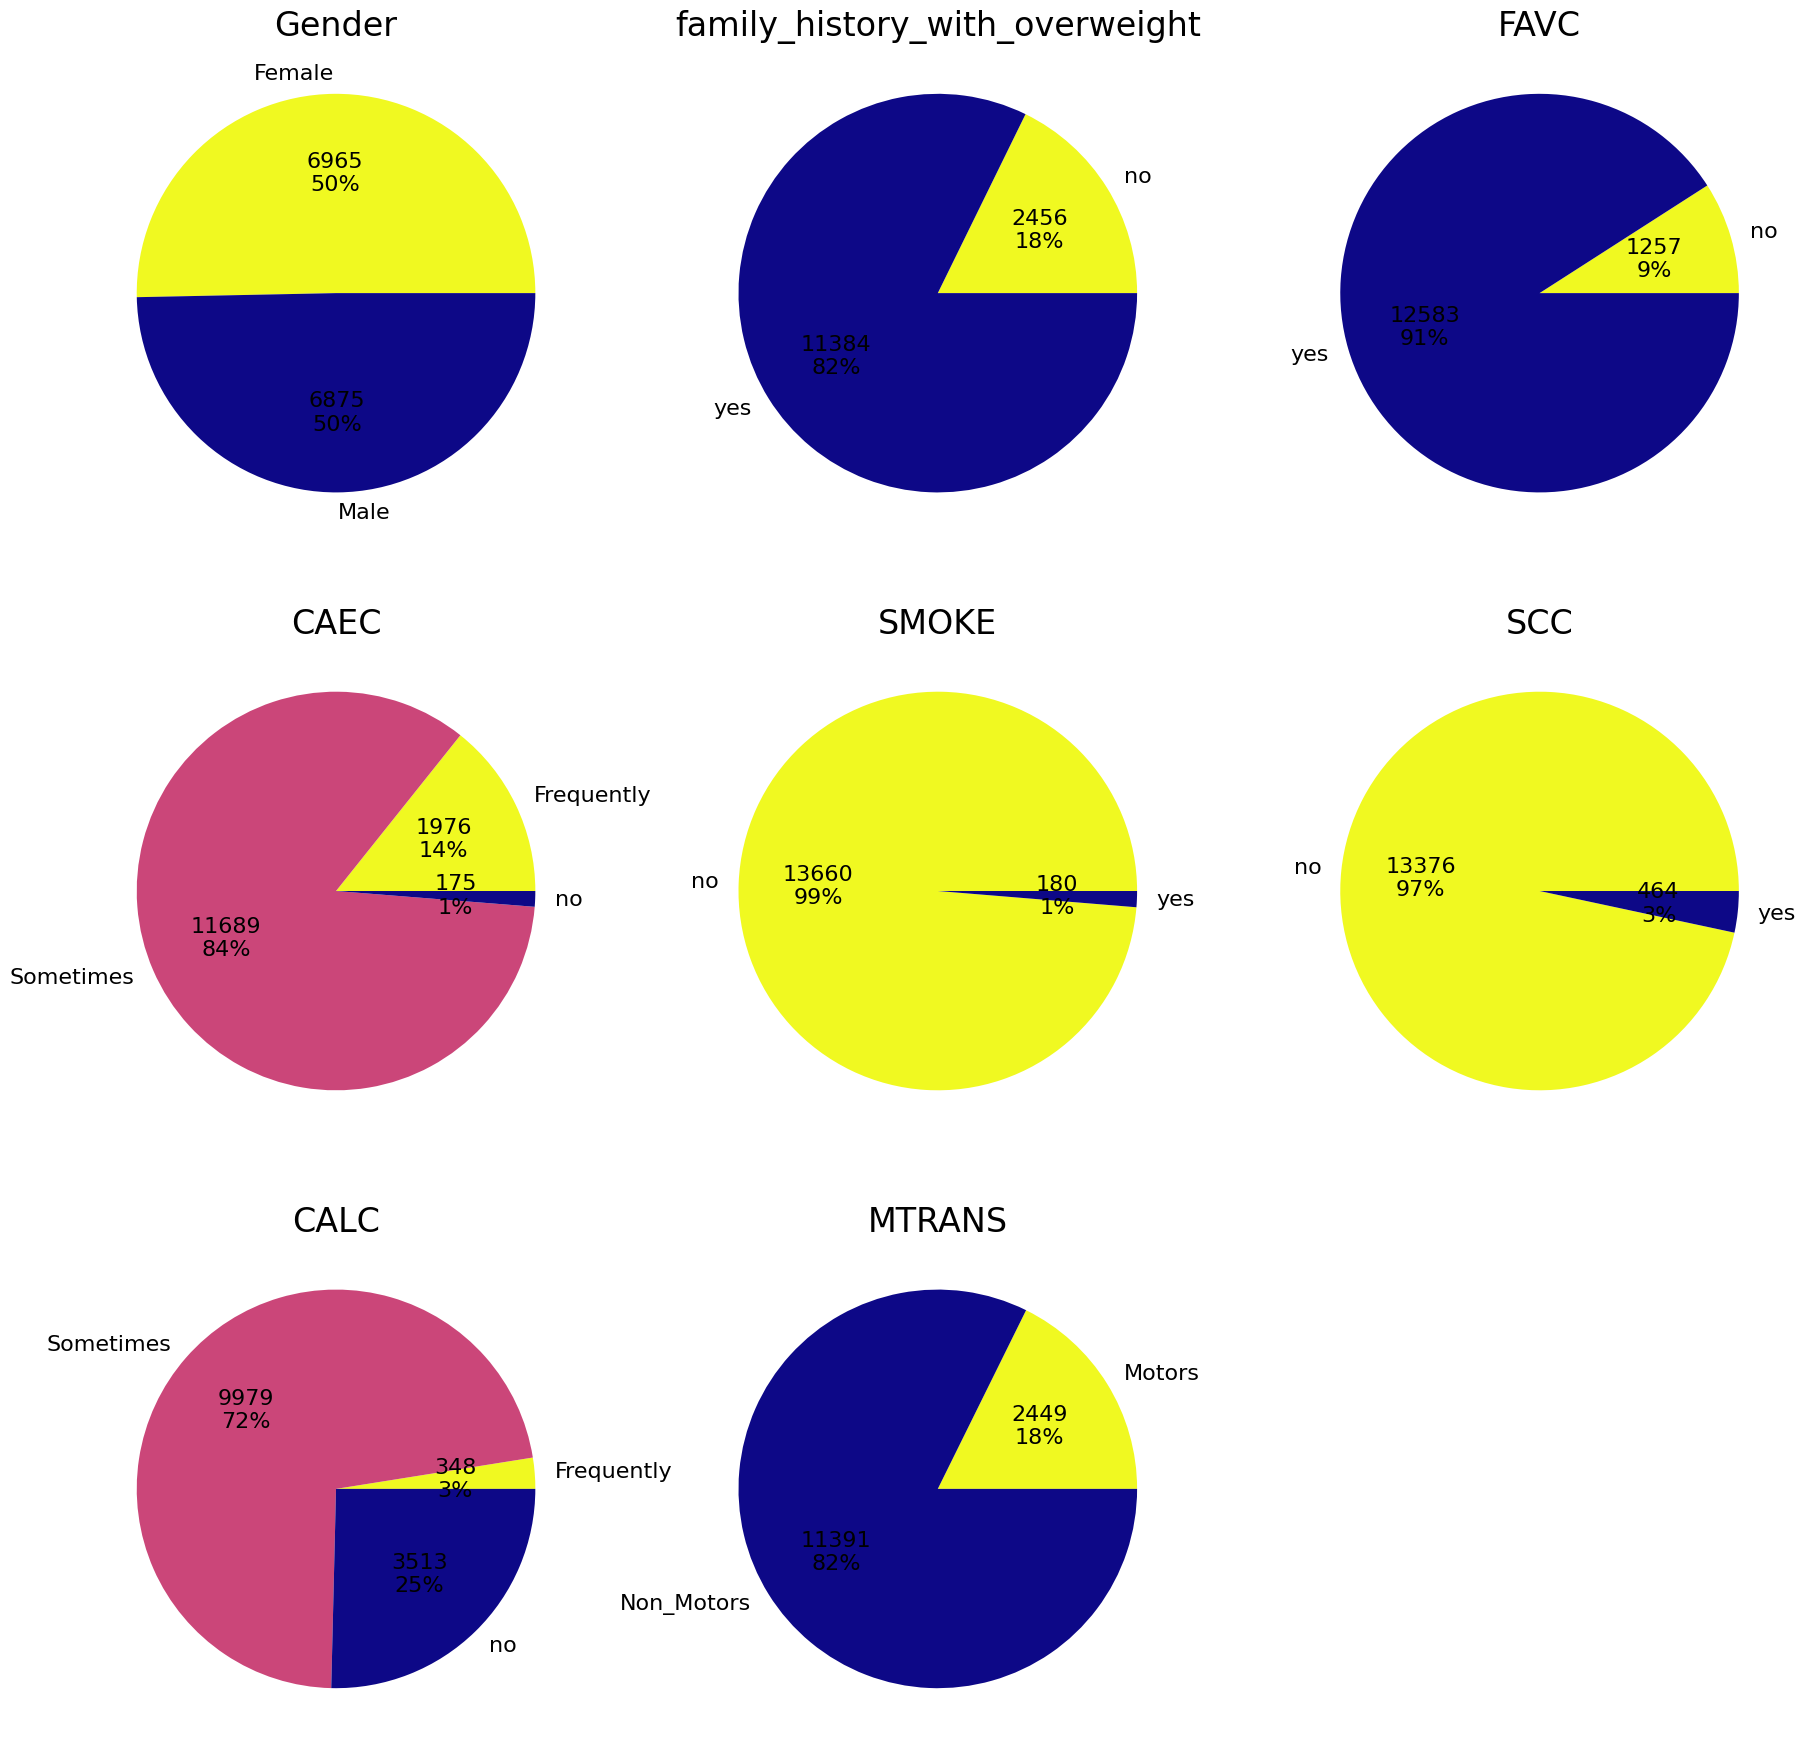

In [170]:
plt.figure(figsize=(22,22))
plt.rcParams["axes.labelsize"] = 20
rows, num = 3, 3
cols = 0

# ref: https://stackoverflow.com/questions/63687789/how-do-i-create-a-pie-chart-using-categorical-data-in-matplotlib
def label_function(val):
  return f'{val / 100 * len(test_cat_cols):.0f}\n{val:.0f}%'   # returns nums and percent
  # return f'{val:.0f}%'

for n in range(rows):
  for i in range(num):
    plt.subplot(3,3,cols+1)
    if len(test_cat_cols.columns) > cols:
      test_cat_cols.groupby(test_cat_cols.columns[cols]).size().plot(kind='pie', 
                                                                     autopct=label_function, 
                                                                     textprops={'fontsize': 16},
                                                                     colormap='plasma_r'
                                                                    )
      plt.title(test_cat_cols.columns[cols])
    cols += 1
    plt.axis('off')

In [171]:
# ref: https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/
train_X.cov(numeric_only=True).style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '20px'}) 

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Age,32.354163,-0.005817,42.520795,0.104378,-0.194509,-0.056501,-0.916753,-1.014289
Height,-0.005817,0.007623,0.959708,-0.003331,0.011787,0.009760,0.021613,0.004018
Weight,42.520795,0.959708,695.875017,3.455769,1.785325,5.102848,-1.876251,-1.373462
FCVC,0.104378,-0.003331,3.455769,0.284322,0.042633,0.032866,-0.040150,-0.047466
NCP,-0.194509,0.011787,1.785325,0.042633,0.497553,0.034743,0.059647,0.028651
CH2O,-0.056501,0.009760,5.102848,0.032866,0.034743,0.370232,0.042302,-0.003903
FAF,-0.916753,0.021613,-1.876251,-0.040150,0.059647,0.042302,0.702750,0.010707
TUE,-1.014289,0.004018,-1.373462,-0.047466,0.028651,-0.003903,0.010707,0.362541


&#128161; <b> from above CoVariance Matrix we can infer by intution that except for<br />
`Weight`, `Age`, `Height`, `FCVC`, `NCP`, `CH2O`<br />
**we can drop the rest**

In [172]:
# ref: https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/
train_X.corr(numeric_only=True).style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '20px'}) 

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
Age,1.000000,-0.011713,0.283381,0.034414,-0.048479,-0.016325,-0.192259,-0.296154
Height,-0.011713,1.000000,0.416677,-0.071546,0.191383,0.183706,0.295278,0.076433
Weight,0.283381,0.416677,1.000000,0.245682,0.095947,0.317914,-0.084845,-0.086471
FCVC,0.034414,-0.071546,0.245682,1.000000,0.113349,0.101299,-0.089822,-0.147843
NCP,-0.048479,0.191383,0.095947,0.113349,1.000000,0.080949,0.100871,0.067459
CH2O,-0.016325,0.183706,0.317914,0.101299,0.080949,1.000000,0.082932,-0.010654
FAF,-0.192259,0.295278,-0.084845,-0.089822,0.100871,0.082932,1.000000,0.021213
TUE,-0.296154,0.076433,-0.086471,-0.147843,0.067459,-0.010654,0.021213,1.000000


&#128161; <b> from above Correlation Matrix we can infer similar stats as inferred in CoVaiance Matrix<br />
`Weight`, `Age`, `Height`, `FCVC`, `NCP`, `CH2O`<br />
**we can drop the rest**

# Datasets - scaling, encoding, PCA

<div class="alert alert-block alert-info"><h4>
For Fully Connected Neural Networks when used to predict majority class for classification problems or predict values against continuous data</h4>
<ul>
<li>StandardScaled</li>
<li>One-Hot Encoder</li>
<li>DecisionTree</li>
<li>PCA</li>
</div>

In [173]:
data_tr = train_X.copy()
data_te = test_X.copy()

In [174]:
train_X = data_tr.copy()
test_X = data_te.copy()

### LabelEncoder - target values

In [175]:
labelEnc = LabelEncoder()
y_encoded = labelEnc.fit_transform(train_Y)

y = tf.keras.utils.to_categorical(y_encoded)

In [176]:
print(y[:10])

[[0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [177]:
# Numerical columns
num_col_ = train_X.select_dtypes(exclude=(['object', 'category'])).columns
print('numerical columns:', num_col_)

# Categorical columns
cat_col_ = train_X.select_dtypes(include=(['object', 'category'])).columns
print('categorical columns:', cat_col_)
# print(train_X.select_dtypes(exclude=(['object', 'category'])).columns)

numerical columns: Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')
categorical columns: Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')


In [178]:
print(type(train_X),'\n', train_X.shape, '\n',  type(test_X), '\n',  test_X.shape)

<class 'pandas.core.frame.DataFrame'> 
 (20758, 16) 
 <class 'pandas.core.frame.DataFrame'> 
 (13840, 16)


### StandardScaler

In [179]:
# StandardScaler
scaler = StandardScaler()                                                                                           
scaler.fit(train_X[num_col_])                                                                                       
train_X_scaler = scaler.transform(train_X[num_col_])                                                                
test_X_scaler = scaler.transform(test_X[num_col_]) 

In [180]:
# Numerical columns
num_col_ = train_X.select_dtypes(exclude=(['object', 'category'])).columns
print('numerical columns:', num_col_)

# Categorical columns
cat_col_ = train_X.select_dtypes(include=(['object', 'category'])).columns
print('categorical columns:', cat_col_)

numerical columns: Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')
categorical columns: Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')


In [181]:
# create a dataframe from train_X_scaler numpy array
df = pd.DataFrame(train_X_scaler, columns=num_col_)
df.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111


<Figure size 300x300 with 0 Axes>

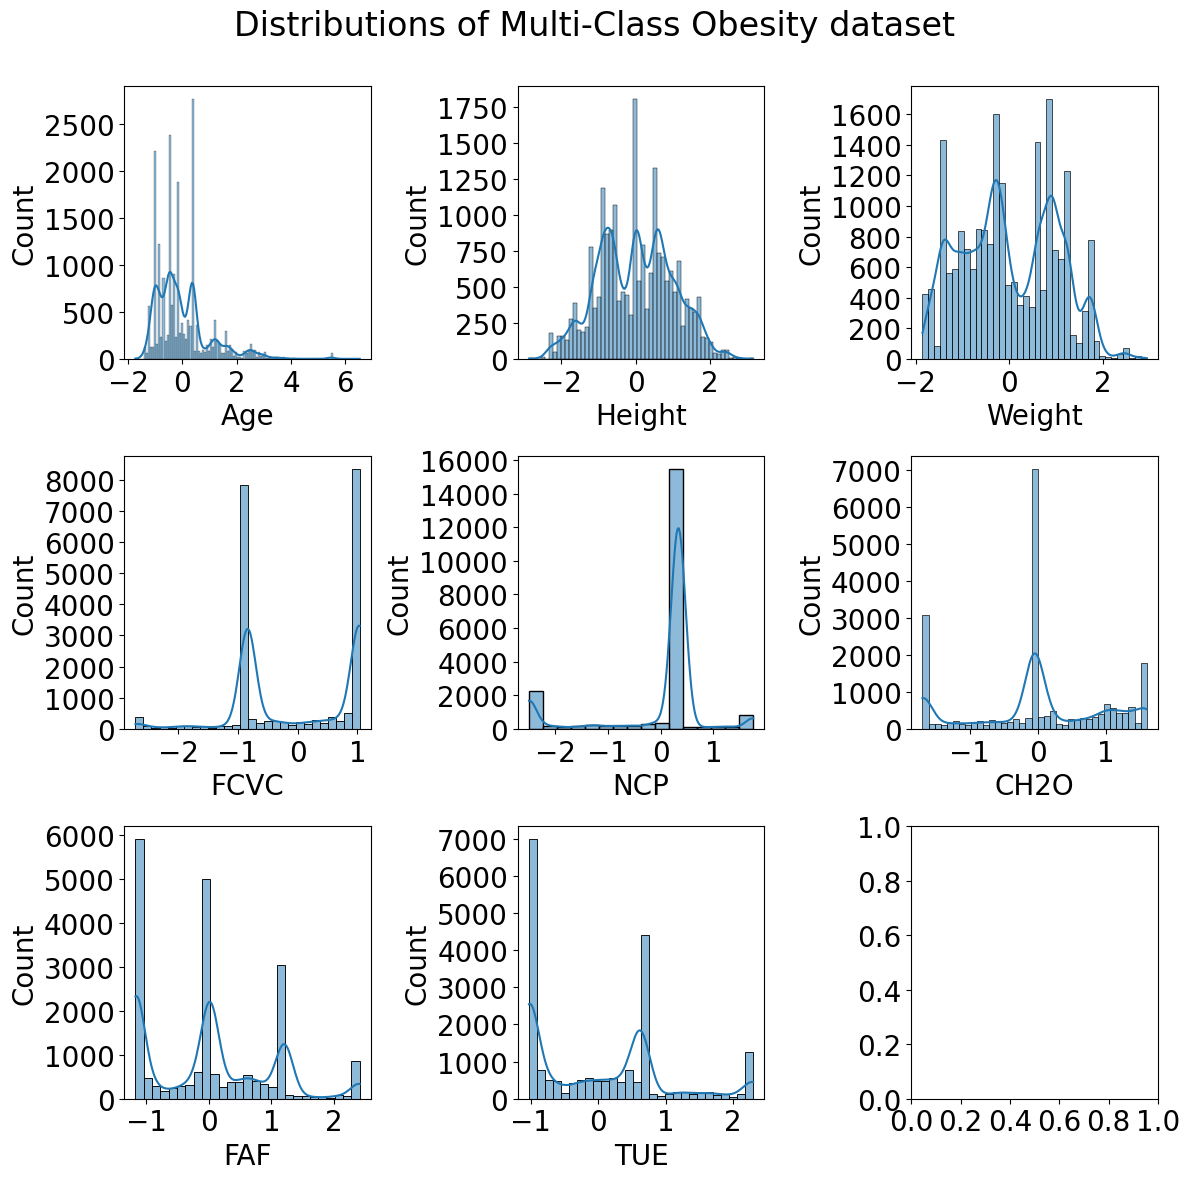

In [182]:
# Plot all features
plt.figure(figsize=(3,3))
plt.subplots_adjust(hspace=0.4)
cols = 3
rows=3
fig,ax = plt.subplots(nrows=rows,ncols=cols,figsize=(12,12))
ax = ax.flatten()
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["font.size"] = 10
truth_label='NObeyesdad'
plt.suptitle("Distributions of Multi-Class Obesity dataset\n",size=24)
# textprops={'fontsize': 16},
xx = 0
for i,col in enumerate(df.columns):
    if col not in cat_col_:
      # print('1',col)
      if col == 'id':    # do not plot 'id'column
        continue
      else:
        sns.histplot(data=df,x=col,ax=ax[xx],kde=True,line_kws={"ls":"-"})
        xx += 1

plt.tight_layout()
plt.show()

#### ref: https://stackoverflow.com/questions/58101126/using-scikit-learn-onehotencoder-with-a-pandas-dataframe  
**OneHotEncoder** for DecisionTrees, PCA, and Neural Networks (when categorical data is present)

### OneHotEncoder

In [183]:
## One-hot encoding removed index; put it back
onhc = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_onhc = pd.DataFrame(onhc.fit_transform(train_X[cat_col_]))
test_onhc = pd.DataFrame(onhc.transform(test_X[cat_col_]))

# One-hot encoding removed index; put it back
train_onhc.index = train_X.index
test_onhc.index = test_X.index

## Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_X.drop(cat_col_, axis=1)
num_X_test = test_X.drop(cat_col_, axis=1)

In [184]:
# get back column names instead of integers
train_onhc.columns = onhc.get_feature_names_out(cat_col_)
test_onhc.columns = onhc.get_feature_names_out(cat_col_)

In [185]:
train_onhc.head()

,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Motors,MTRANS_Non_Motors
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [186]:
#  convert Numpy array to DataFrame
train_X_scaled = pd.DataFrame(train_X_scaler, index=train_X.index, columns=num_col_)
test_X_scaled = pd.DataFrame(test_X_scaler, index=test_X.index, columns=num_col_)

In [187]:
train_X_scaled.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,0.105699,-0.002828,-0.235713,-0.836279,0.314684,1.206594,-1.171141,0.597438
1,-1.027052,-1.606291,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513
2,-1.027052,0.128451,-1.430012,-1.060332,-1.913423,-0.195644,-0.138022,1.755239
3,-0.507929,0.120090,1.644770,1.039171,0.338364,-0.584035,0.579896,0.271455
4,1.371197,2.450367,0.224054,0.438397,-1.119801,-0.081469,1.176486,0.523111


In [188]:
## Add one-hot encoded columns to numerical features
train_X_new = pd.concat([train_X_scaled, train_onhc], axis=1)
test_X_new = pd.concat([test_X_scaled, test_onhc], axis=1)

In [189]:
train_X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 20758 non-null  float64
 1   Height                              20758 non-null  float64
 2   Weight                              20758 non-null  float64
 3   FCVC                                20758 non-null  float64
 4   NCP                                 20758 non-null  float64
 5   CH2O                                20758 non-null  float64
 6   FAF                                 20758 non-null  float64
 7   TUE                                 20758 non-null  float64
 8   Gender_Female                       20758 non-null  float64
 9   Gender_Male                         20758 non-null  float64
 10  family_history_with_overweight_no   20758 non-null  float64
 11  family_history_with_overweight_yes  20758

In [190]:
train_X_new.cov(numeric_only=True).style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '20px'}) 

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Motors,MTRANS_Non_Motors
Age,1.000048,-0.011713,0.283395,0.034416,-0.048481,-0.016326,-0.192268,-0.296169,-0.033266,0.033266,-0.100578,0.100578,-0.015902,0.015902,-0.067088,0.072993,-0.005905,-0.006049,0.006049,0.019474,-0.019474,0.005690,0.021932,-0.027622,0.228386,-0.228386
Height,-0.011713,1.000048,0.416698,-0.071550,0.191392,0.183715,0.295293,0.076436,-0.311766,0.311766,-0.087721,0.087721,-0.032326,0.032326,-0.037526,0.046517,-0.008991,-0.007533,0.007533,0.017160,-0.017160,0.006009,0.030208,-0.036216,0.021221,-0.021221
Weight,0.283395,0.416698,1.000048,0.245694,0.095952,0.317930,-0.084849,-0.086476,-0.059309,0.059309,-0.197694,0.197694,-0.063992,0.063992,-0.145026,0.154610,-0.009583,-0.004365,0.004365,0.033116,-0.033116,-0.007568,0.117774,-0.110206,-0.002624,0.002624
FCVC,0.034416,-0.071550,0.245694,1.000048,0.113354,0.101303,-0.089826,-0.147850,0.156389,-0.156389,-0.018363,0.018363,-0.001945,0.001945,0.000603,0.008115,-0.008718,0.001317,-0.001317,-0.003957,0.003957,-0.005793,0.072596,-0.066803,-0.036130,0.036130
NCP,-0.048481,0.191392,0.095952,0.113354,1.000048,0.080953,0.100876,0.067462,-0.019735,0.019735,-0.017217,0.017217,-0.003223,0.003223,0.022116,-0.008350,-0.013765,-0.000737,0.000737,-0.001187,0.001187,-0.000535,0.048166,-0.047631,0.003123,-0.003123
CH2O,-0.016326,0.183715,0.317930,0.101303,0.080953,1.000048,0.082936,-0.010654,-0.026650,0.026650,-0.073667,0.073667,-0.010956,0.010956,-0.052756,0.047775,0.004981,0.002535,-0.002535,0.005674,-0.005674,-0.000170,0.039532,-0.039362,-0.025997,0.025997
FAF,-0.192268,0.295293,-0.084849,-0.089826,0.100876,0.082936,1.000048,0.021214,-0.119204,0.119204,0.036303,-0.036303,0.018750,-0.018750,0.036075,-0.038272,0.002197,-0.000904,0.000904,-0.011061,0.011061,0.008166,-0.059001,0.050835,-0.000908,0.000908
TUE,-0.296169,0.076436,-0.086476,-0.147850,0.067462,-0.010654,0.021214,1.000048,-0.029349,0.029349,-0.002215,0.002215,-0.009746,0.009746,0.013452,-0.007267,-0.006186,0.001738,-0.001738,0.001416,-0.001416,0.003441,-0.044678,0.041237,-0.068057,0.068057
Gender_Female,-0.033266,-0.311766,-0.059309,0.156389,-0.019735,-0.026650,-0.119204,-0.029349,0.250008,-0.250008,0.018415,-0.018415,0.003051,-0.003051,0.009919,-0.008470,-0.001449,0.003421,-0.003421,-0.005496,0.005496,-0.004365,0.017574,-0.013210,-0.028736,0.028736
Gender_Male,0.033266,0.311766,0.059309,-0.156389,0.019735,0.026650,0.119204,0.029349,-0.250008,0.250008,-0.018415,0.018415,-0.003051,0.003051,-0.009919,0.008470,0.001449,-0.003421,0.003421,0.005496,-0.005496,0.004365,-0.017574,0.013210,0.028736,-0.028736


&#128308; Some of the Categorical columns after OneHotEncoding do add to accuracy of the model

In [191]:
train_X_new.corr(numeric_only=True).style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '20px'}) 

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Motors,MTRANS_Non_Motors
Age,1.000000,-0.011713,0.283381,0.034414,-0.048479,-0.016325,-0.192259,-0.296154,-0.066530,0.066530,-0.261575,0.261575,-0.056848,0.056848,-0.192128,0.201389,-0.051281,-0.056006,0.056006,0.108855,-0.108855,0.036106,0.049159,-0.063896,0.602920,-0.602920
Height,-0.011713,1.000000,0.416677,-0.071546,0.191383,0.183706,0.295278,0.076433,-0.623507,0.623507,-0.228137,0.228137,-0.115566,0.115566,-0.107468,0.128341,-0.078078,-0.069748,0.069748,0.095923,-0.095923,0.038126,0.067710,-0.083777,0.056022,-0.056022
Weight,0.283381,0.416677,1.000000,0.245682,0.095947,0.317914,-0.084845,-0.086471,-0.118613,0.118613,-0.514147,0.514147,-0.228770,0.228770,-0.415330,0.426569,-0.083220,-0.040416,0.040416,0.185116,-0.185116,-0.048021,0.263987,-0.254933,-0.006928,0.006928
FCVC,0.034414,-0.071546,0.245682,1.000000,0.113349,0.101299,-0.089822,-0.147843,0.312766,-0.312766,-0.047756,0.047756,-0.006952,0.006952,0.001727,0.022390,-0.075708,0.012191,-0.012191,-0.022120,0.022120,-0.036760,0.162723,-0.154531,-0.095381,0.095381
NCP,-0.048479,0.191383,0.095947,0.113349,1.000000,0.080949,0.100871,0.067459,-0.039468,0.039468,-0.044778,0.044778,-0.011522,0.011522,0.063335,-0.023038,-0.119536,-0.006820,0.006820,-0.006633,0.006633,-0.003395,0.107963,-0.110182,0.008244,-0.008244
CH2O,-0.016325,0.183706,0.317914,0.101299,0.080949,1.000000,0.082932,-0.010654,-0.053298,0.053298,-0.191588,0.191588,-0.039167,0.039167,-0.151084,0.131811,0.043255,0.023475,-0.023475,0.031720,-0.031720,-0.001081,0.088611,-0.091054,-0.068629,0.068629
FAF,-0.192259,0.295278,-0.084845,-0.089822,0.100871,0.082932,1.000000,0.021213,-0.238399,0.238399,0.094414,-0.094414,0.067030,-0.067030,0.103311,-0.105593,0.019082,-0.008374,0.008374,-0.061828,0.061828,0.051813,-0.132248,0.117593,-0.002397,0.002397
TUE,-0.296154,0.076433,-0.086471,-0.147843,0.067459,-0.010654,0.021213,1.000000,-0.058696,0.058696,-0.005762,0.005762,-0.034843,0.034843,0.038525,-0.020049,-0.053714,0.016093,-0.016093,0.007917,-0.007917,0.021833,-0.100145,0.095392,-0.179664,0.179664
Gender_Female,-0.066530,-0.623507,-0.118613,0.312766,-0.039468,-0.053298,-0.238399,-0.058696,1.000000,-1.000000,0.095786,-0.095786,0.021812,-0.021812,0.056813,-0.046738,-0.025167,0.063349,-0.063349,-0.061442,0.061442,-0.055389,0.078786,-0.061115,-0.151720,0.151720
Gender_Male,0.066530,0.623507,0.118613,-0.312766,0.039468,0.053298,0.238399,0.058696,-1.000000,1.000000,-0.095786,0.095786,-0.021812,0.021812,-0.056813,0.046738,0.025167,-0.063349,0.063349,0.061442,-0.061442,0.055389,-0.078786,0.061115,0.151720,-0.151720


<div class="alert alert-block alert-info"><h1>Decision Tree</h1></div>

In [192]:
labels = list(train_Y.unique())
train_X_numericals = train_X_new.select_dtypes(exclude=['object','category'])
n_features = train_X_numericals.shape[1]
feature_names = train_X_new.select_dtypes(exclude=['object','category']).columns

In [193]:
print('labels: ', labels, end='\n')
#  print('Numerals: ', train_X_numericals, end='\n')
print('Num Features: ', n_features, end='\n')
print('Feature Name: ', feature_names, end='\n')

labels:  ['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight', 'Obesity_Type_III', 'Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_I']
Num Features:  26
Feature Name:  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Female', 'Gender_Male', 'family_history_with_overweight_no',
       'family_history_with_overweight_yes', 'FAVC_no', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_no', 'SMOKE_yes',
       'SCC_no', 'SCC_yes', 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no',
       'MTRANS_Motors', 'MTRANS_Non_Motors'],
      dtype='object')


**Here we are only at a max depth of `4`, we can increase by why `4`?**

In [194]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(train_X_numericals, train_Y)

DecisionTreeClassifier(max_depth=4, random_state=0)

In [195]:
print(f'Tree Feature Importance: {tree.feature_importances_}')

Tree Feature Importance: [4.87798518e-02 5.73804547e-02 5.89176969e-01 3.55189616e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.97490087e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.35368676e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.67053832e-04]


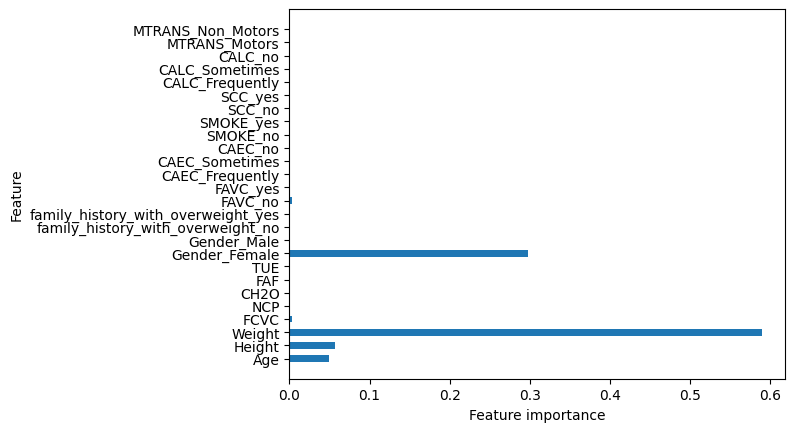

In [196]:
def plot_feature_importances(model, n_features, feature_names):
  n_features = n_features
  feature_names = feature_names
  plt.barh(range(n_features), model.feature_importances_, align='center', height=0.5)
  plt.yticks(np.arange(n_features), feature_names)
  plt.xlabel("Feature importance")
  plt.ylabel("Feature")
  
plot_feature_importances(tree, n_features, feature_names)

&#128161; from the above we see `Weight`. `Height`, `Age`, and `Gender` seem to stand-out.
- categories with most influence on target values

In [197]:
from sklearn.tree import export_graphviz
outfile = 'tree.dot'
export_graphviz(tree, out_file=outfile, 
                class_names=labels, 
                feature_names=feature_names)


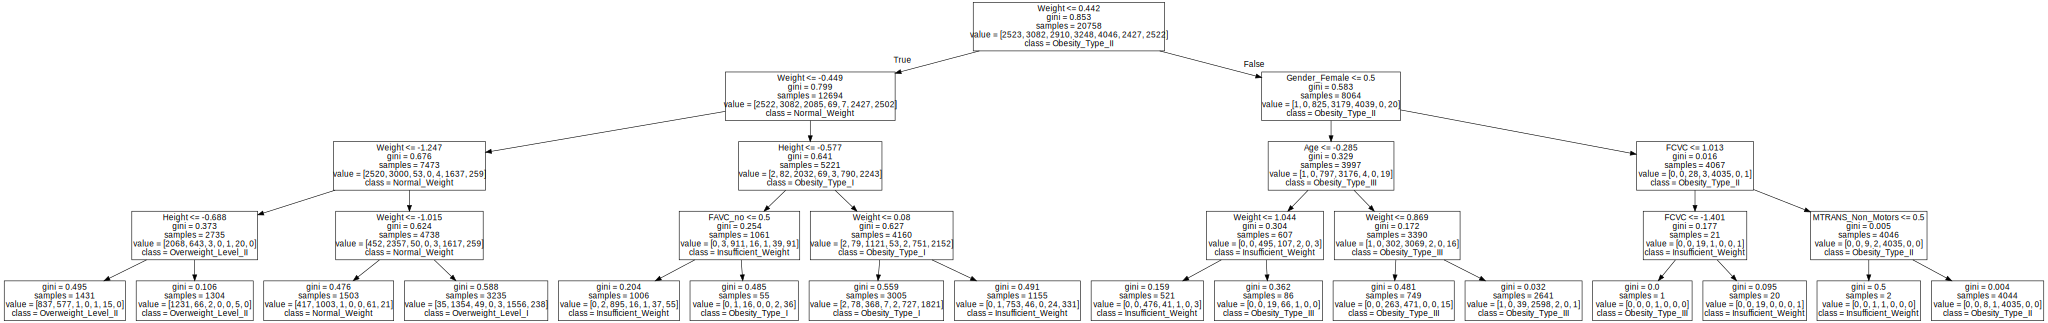

In [198]:
import graphviz as graphviz
with open(outfile) as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

<div class="alert alert-block alert-info"><h1>Final Data Explortion - one last look</h1></div>

In [199]:
# Since this is a sanity check turned most of the statements OFF
# print stats of categorical columns
df = print_stats(train_X_new, test_X_new)
print(df)

# type(train_X_new), train_X_new.shape, train_X_new.columns
# train_X_new.info(show_counts=False)
# train_X_new.describe().transpose()
# type(test_X_new), test_X_new.shape, test_X_new.columns
# print(train_X_new.isnull().sum() !=0)
print ('No Null values in train dataset') if not 1 in train_X_new.isnull().sum() else print(train_X_new.isnull().sum())

# print(test_X_new.isnull().sum() !=0)
print ('No Null values in test dataset') if not 1 in test_X_new.isnull().sum() else print(test_X_new.isnull().sum())


Empty DataFrame
Columns: [Train-Totals, Train-Values, Test-Totals, Test-Values, Diff %, Diff/Sum]
Index: []
No Null values in train dataset
No Null values in test dataset


<div class="alert alert-block alert-info"><h1>Train Test split and Data Augmentation</h1></div>

In [200]:
## PCA ERROR - Feature names are only supported if all input features have string names,
## but your input has ['int', 'str'] as feature name / column name types.
train_X_new.columns = train_X_new.columns.astype(str)
test_X_new.columns = test_X_new.columns.astype(str)

In [201]:
# convert train_X_new to Numpy Array to stack
X = train_X_new.to_numpy() 
X_test = test_X_new.to_numpy() 

# select between using valX, valY or a subset of training data as validation
USE_VAL_BATCH_DATA = True 
USE_TEST_SET = True if USE_VAL_BATCH_DATA else False 

# split for testX, testY ebfore adding values to training, validation 
split_ratio = 0.4  ## split ratio for validation
if USE_VAL_BATCH_DATA:
  trainX, valX, trainY, valY = train_test_split(X, y,
                                                test_size=split_ratio,
                                                shuffle=True,
                                                random_state=42) 
  
  valX, testX, valY, testY = train_test_split(valX, valY,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=42)


### Augment train dataset with random values and vertical stack data to increase sample size

<div class="alert alert-block alert-info"><h4>
<b>Ref:</b>

[barbagrande007](https://www.kaggle.com/code/barbagrande007/bbg007-s4e2-obesity)

<br>Add jittering. Introduce noise to X to increase data size, similar to image augmentation techniques in Convolutional Neural Networks.
  <ul>
  <li>Creates more training samples
  <li>decreases overfitting
  <li>improves accuracy and predictability
  </ul>
  
</h4></div>

In [202]:
# Needs to be done before PCA
dng1 = np.random.default_rng(seed=42)
dng2 = np.random.default_rng(seed=46)
dng3 = np.random.default_rng(seed=0)

X_jitter1 = trainX + dng1.random(1) * 0.3
X_jitter2 = trainX + dng2.random(1) * 0.3
X_jitter3 = trainX + dng3.random(1) * 0.3

## Duplicate trainX, trainY - COMMENT OUT those we don't need
trainX = np.vstack((trainX, 
                    X_jitter1, 
                    X_jitter2,
                    X_jitter3,
                   ))

trainY = np.vstack((trainY,
                    trainY,
                    trainY,
                    trainY,
                   ))

# delete jitter arrays
del X_jitter1, X_jitter2, X_jitter3

## recreate train_X_new from X, and train_X_new.columns list
trainX_new_columns = train_X_new.columns 
del train_X_new 
train_X_new = pd.DataFrame((trainX), columns=trainX_new_columns)

<div class="alert alert-block alert-info"><h1>PCA (Principal Component Analysis)</h1></div>

In [203]:
# PCA analysis
# convert all columns to string type
train_X_new.columns = train_X_new.columns.astype(str)
test_X_new.columns = test_X_new.columns.astype(str)

# we are going for an accuracy of 95%
# n_components = 4
pca_ = PCA(0.95) # using only one component
# pca_ = PCA(n_components=n_components)
# pca_ = PCA()
pca_.fit(train_X_new)

PCA(n_components=0.95)

In [204]:
# SCREE plot
# https://statisticsglobe.com/scree-plot-pca-python
prop_var = pca_.explained_variance_ratio_
eigenvalues = pca_.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues) 

print('Explained variation per principal component: {}'.format(pca_.explained_variance_ratio_))
print('num of components: ', pca_.n_components_)

Explained variation per principal component: [0.19556415 0.16570997 0.12277916 0.09887099 0.09177597 0.07308184
 0.06390354 0.04447439 0.03257382 0.02009804 0.01839486 0.01718112
 0.01570366]
num of components:  13


In [205]:
print(prop_var)

[0.20368899 0.1725945  0.12788011 0.10297865 0.09558887 0.07611807
 0.06655845 0.04632211 0.03392713 0.02093302 0.01915908 0.01789492
 0.01635608]


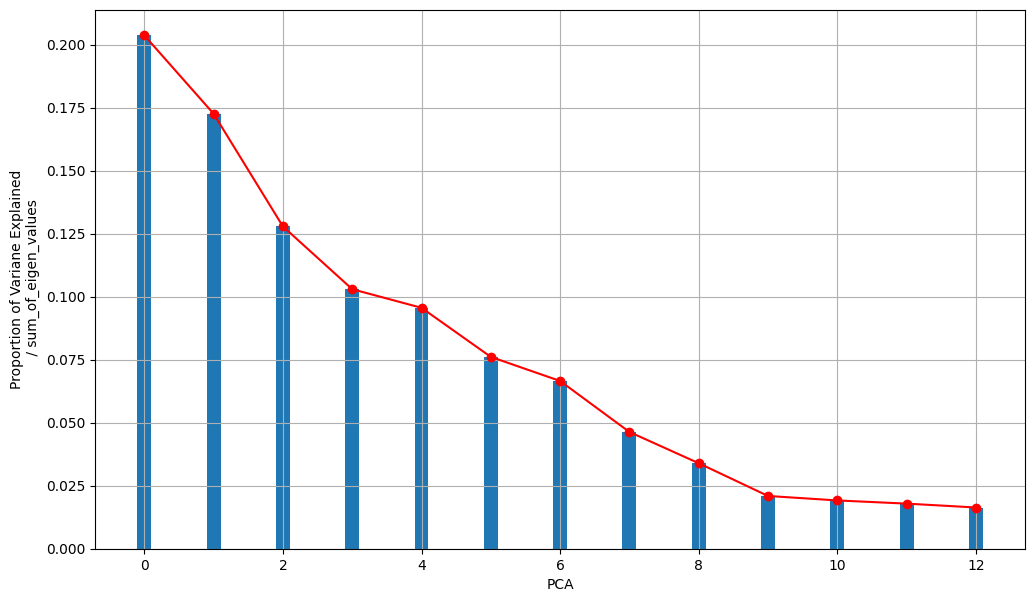

In [206]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(prop_var) ), prop_var, 'ro-')
plt.bar(np.arange(0, len(prop_var) ), prop_var, width=0.2)
plt.xlabel('PCA')
plt.ylabel('Proportion of Variane Explained\n / sum_of_eigen_values')
plt.grid(True)

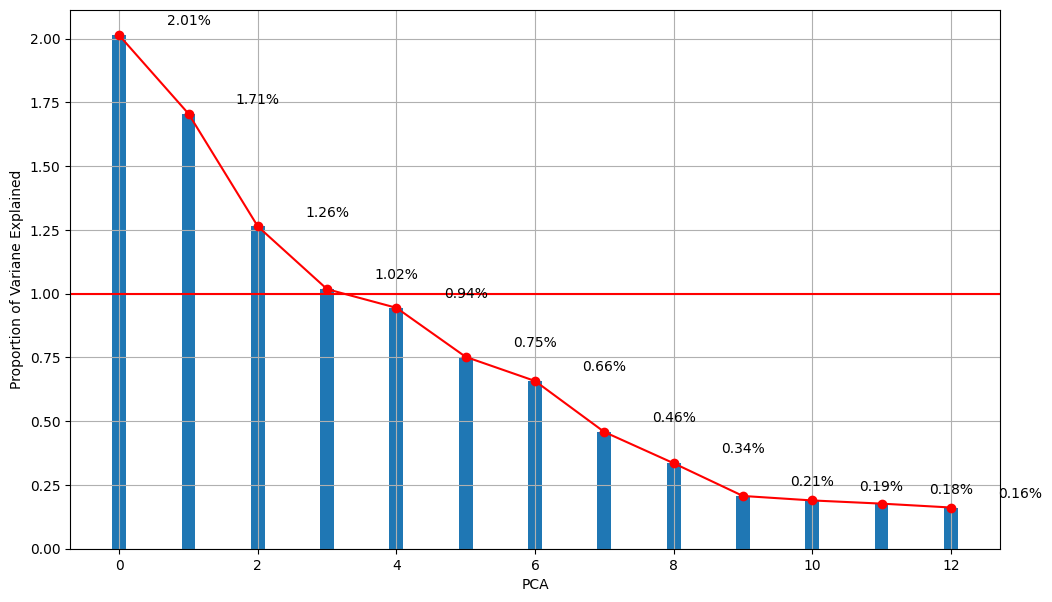

In [207]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(eigenvalues) ), eigenvalues, 'ro-')
plt.bar(range(0, len(eigenvalues)), eigenvalues, width=0.2)
plt.axhline(y=1.0, color='r', label='--')
for i, v in enumerate(eigenvalues):
    label = "{:.2f}%".format(v)
    plt.text(i+1, v+.04, label, ha="center")

plt.xlabel('PCA')
plt.ylabel('Proportion of Variane Explained')
plt.grid(True)

&#128161; As you see from aboe the cut-off point for eigen values is 1.00, and 4 meet the criteria.  
we can increase to `5` to check accuracy and convergence

In [208]:
# components
comps = pca_.components_
print('components: ', comps[:2])

components:  [[-0.22731736 -0.51767596 -0.57453519 -0.14895052 -0.23456231 -0.38055569
  -0.13172989  0.05064717  0.12972578 -0.15564146  0.11755901 -0.1434747
   0.02269845 -0.04861413  0.06795669 -0.10139752 -0.0054327  -0.00849648
  -0.0174192  -0.03316522  0.00724953 -0.01280385 -0.0831227   0.05705302
  -0.05066323  0.02474755]
 [-0.48635464  0.34101315 -0.20498192 -0.31274036  0.17027458  0.02669299
   0.46973759  0.4097204  -0.16109326  0.16704924  0.05624771 -0.05029173
   0.01595204 -0.00999606  0.05734266 -0.0530677   0.00465901  0.0036021
   0.00235388 -0.00613281  0.01208879  0.00877087 -0.06863579  0.06879889
  -0.07870373  0.08465972]]


In [209]:
## already NUMPY array 
trainX = pca_.transform(trainX)
X_test = pca_.transform(test_X_new)

In [210]:
if USE_VAL_BATCH_DATA:
  valX = pca_.transform(valX)

if USE_TEST_SET:
  testX = pca_.transform(testX)

## end scaling, encoding, and PCA analysis

In [211]:
## check shapes of all 3 sets
print(f'Train  : X:{trainX.shape} Y:{trainY.shape}')

if USE_VAL_BATCH_DATA:
  print(f'Val    : X:{valX.shape}   Y:{valY.shape}')

if USE_TEST_SET:
  print(f'Test  : X:{testX.shape} Y:{testY.shape}')

Train  : X:(49816, 13) Y:(49816, 7)
Val    : X:(4152, 13)   Y:(4152, 7)
Test  : X:(4152, 13) Y:(4152, 7)


# Deep Neural Network - Tensorflow -> Keras

<div class="alert alert-block alert-info"><h4>
Imported packages - most are not used in this Notebook, similar setup can be used to Keras_Tune hyperparameters for Convolutional Neural Networks
</h4></div>

In [212]:
import tensorflow.keras as keras
import keras.backend as K

from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Input
from keras.layers import ReLU, LeakyReLU

from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from  keras.regularizers import L1 , L2, L1L2
import  keras.regularizers as regularizers
from keras.optimizers import Adam, SGD
from tensorflow.keras.backend import clear_session

<div class="alert alert-block alert-info"><h1>model callbacks</h1></div>

In [213]:
# ModelCheckpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='obesity.hd5',
  save_weights_only=False,         # only save weights
  monitor='val_accuracy',
  mode='max',
  save_best_only=True,
)

# Reduce Learning Rate
# Giving ERROR when enabled - doesn't work when assigning Learning_Rate to Adam
reduce_lr = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.04,
  patience=5,
  min_lr=0.0,
)

# Early Stopping
early_stop = EarlyStopping(
  monitor='val_loss',
  mode='auto',
  verbose=0,
  patience=10,
)


In [214]:
class My_Callback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
      self.epoch = epoch

    def on_batch_end(self, batch, logs={}):
        # if self.epoch == 10 and batch == 3:
        if self.epoch == 10:
          print (f"\nStopping at Epoch {self.epoch}, Batch {batch}")
          self.model.stop_training = True

    # def on_epoch_end(self, epoch, logs={}):
    #     if self.epoch == 20:
    #        print (f"\nStopping at Epoch {self.epoch}")
    #      # cannot access self.model.stop_training in this function - check source

In [215]:
class TerminateOnOne(keras.callbacks.Callback):
  def __init__(self, monitor='accuracy', baseline=0.9):
    super(TerminateOnOne, self).__init__()
    self.monitor = monitor
    self.baseline = baseline

  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    acc = logs.get(self.monitor)
    if acc is not None and acc >= self.baseline:
      print(f'stopping at epoch: {epoch}')
      self.model.stop_training = True



<div class="alert alert-block alert-info"><h4>
The function below is a stand-alone function and uses the following <b>hyperparameters</b> to tune Neural Network to improve validation accuracy and decrease training and validation loss.<br>
  <ul>
    <li>batch_size - same is referenced in 'HyperTuningNetwork' class but name is different</li>
    <li>epochs - number of epochs in run</li>
    <li>layer1 - Number of Neurons in first fully connected Dense layer</li>
    <li>layer2 - A float to scale the number of neurons in layer1 and use as Number of Neurons in second fully connected Dense layer</li>
    <li>l2_reg - Float - value of Kernel_regularizer - L2</li>
    <li>learning_rate - To setup learning_rate_scheduler for Adam - Model optimizer</li>
    <li>decay_steps - To setup learning_rate_scheduler for Adam - Model optimizer</li>
    <li>decay_rate - To setup learning_rate_scheduler for Adam - Model optimizer</li>
  </ul>
</h4></div>

<div class="alert alert-block alert-info"><h1>create & build model</h1></div>

In [216]:
# Functional Model
def build_keras_model():
  keras.backend.clear_session()       # turn-off and check how Keras_Tuner behaves
 
  # setup up parameter search values for batch_size
  # # This is also setup in 'HyperTuningNetwork' class - 'fit' function
  hp_batch_size = hp.Int(name="batch_sizes",     # name that is referenced in tuning
                         min_value=10,          # 20% below your base search number
                         max_value=512,         # 20% above your base search number
                         step=11,                # steps to increment in searched (linear increase)
                         # default=1024,           # this is your base search number
  )

  # setup up parameter search values for epochs
  hp_epochs_size = hp.Int(name="epochs_sizes",   # name that is referenced in tuning
                          min_value=10,          # -20% below your base
                          max_value=500,         # +20% above your base
                          step=10,               # linear increment steps
                          # default=90,            # base search number that brought you to 80+%
  )

  tr_shape = trainX.shape[1]                     # don't really - using to shorten name
  num_classes = trainY.shape[1]                  # same reason as above

  # choose for initializer
  # For initializer we use 'Choice' - since this is not a conitnuous number but discrete
  
  # Input
  model = Sequential()   # define Sequental Model
  model.add(Input(shape=(trainX.shape[1],)))
  
  #### build layers
  ## choose kernel regularizer and values 
  hp_knrg1 = hp.Choice('krnl_reg1', values=['l1', 'l2'])
  hp_knvl1 = hp.Float('krnl_vals1', min_value=1e-4, max_value=1e-2, sampling='log')
  hp_knrg2 = hp.Choice('krnl_reg2', values=['l1', 'l2'])
  hp_knvl2 = hp.Float('krnl_vals2', min_value=1e-4, max_value=1e-2, sampling='log')

  krnl_reg1=regularizers.L1(hp_knvl1) if hp_knrg1 == 'l1' else regularizers.L2(hp_knvl1)             # kernel
  krnl_reg2=regularizers.L1(hp_knvl2) if hp_knrg2 == 'l1' else regularizers.L2(hp_knvl2)
 
  ## choose bias regularizer and values 
  hp_bsrg1 = hp.Choice('bias_reg1', values=['l1', 'l2'])
  hp_bsvl1 = hp.Float('bias_vals1', min_value=1e-4, max_value=1e-2, sampling='log')
  hp_bsrg2 = hp.Choice('bias_reg2', values=['l1', 'l2'])
  hp_bsvl2 = hp.Float('bias_vals2', min_value=1e-4, max_value=1e-2, sampling='log')
 
  bias_reg1=regularizers.L1(hp_bsvl1) if hp_bsrg1 == 'l1' else regularizers.L2(hp_bsvl1)             # bias
  bias_reg2=regularizers.L1(hp_bsvl2) if hp_bsrg2 == 'l1' else regularizers.L2(hp_bsvl2)

  # choose activity regularizer and values 
  hp_acrg1 = hp.Choice('act_reg1', values=['l1', 'l2'])
  hp_acvl1 = hp.Float('act_vals1', min_value=1e-4, max_value=1e-2, sampling='log')
  hp_acrg2 = hp.Choice('act_reg2', values=['l1', 'l2'])
  hp_acvl2 = hp.Float('act_vals2', min_value=1e-4, max_value=1e-2, sampling='log')

  acti_reg1=regularizers.L1(hp_acvl1) if hp_acrg1 == 'l1' else regularizers.L2(hp_acvl1)             # activity
  acti_reg2=regularizers.L1(hp_acvl2) if hp_acrg2 == 'l1' else regularizers.L2(hp_acvl2)

  ## kernel_initializer
  krnl_init1 = hp.Choice('initial1', values=['glorot_uniform', 'glorot_normal', 'he_normal', 'uniform', 'he_uniform'], default='glorot_uniform',)
  krnl_init2 = hp.Choice('initial2', values=['glorot_uniform', 'glorot_normal', 'he_normal', 'uniform', 'he_uniform'], default='glorot_uniform',)

  ## activation
  # activ1=hp.Choice('activ1', values=['relu', 'tanh', 'sigmoid', 'selu', 'elu', 'hard_sigmoid', 'linear'],)
  # activ2=hp.Choice('activ2', values=['relu', 'tanh', 'sigmoid', 'selu', 'elu', 'hard_sigmoid', 'linear'],)
  activ1=hp.Choice('activ1', values=['relu', 'tanh', 'sigmoid'])
  activ2=hp.Choice('activ2', values=['relu', 'tanh', 'sigmoid'])

  # Dense Layer setup
  units1 = hp.Int('units1', min_value=10, max_value=500, step=10, sampling='linear')
  model.add(Dense(units=units1,
                  kernel_regularizer=krnl_reg1,
                  bias_regularizer=bias_reg1,
                  activity_regularizer=acti_reg1,
                  kernel_initializer = krnl_init1,
                  activation= activ1,
                  )) 

  drop1 = hp.Float('drop1', min_value=0.2, max_value=0.9, step=0.05, default=0.2, sampling='linear')
  model.add(Dropout(drop1))
  model.add(BatchNormalization())

  # Dense Layer setup
  units2 = hp.Int('units2', min_value=10, max_value=500, step=5, sampling='linear')
  model.add(Dense(units=units2,
                  kernel_regularizer=krnl_reg2,
                  bias_regularizer=bias_reg2,
                  activity_regularizer=acti_reg2,
                  kernel_initializer = krnl_init2,
                  activation=  activ2,
                  )) 

  drop2 = hp.Float('drop2', min_value=0.2, max_value=0.9, step=0.05, default=0.2, sampling='linear')
  model.add(Dropout(drop2))
  model.add(BatchNormalization())

  #### OUT ####
  model.add(Dense(num_classes, activation='softmax',))
  
  ##################################################################
  ## To setup learning_rate_scheduler for Adam - Model optimizer
  hp_learning_rate = hp.Float('learning_rate', 1e-5, 1e-1, sampling='log')
  hp_decay_steps = hp.Float('decay_steps', min_value=10, max_value=50000, step=50)
  hp_decay_rate = hp.Float('decay_rate', min_value=0.1, max_value=1.0, sampling='log')
 

  ##################################################################
  # tensorflow.keras.optimizers.schedules.ExponentialDecay
  lr_schedule = ExponentialDecay(initial_learning_rate=hp_learning_rate, 
                                 decay_steps=hp_decay_steps,
                                 decay_rate=hp_decay_rate,
                                )

  # setup optimizer
  optimizer = hp.Choice("optimizers", values=['sgd', 'adagrad', 'adamax', 'adam'])

  # get optimizer from tensorflow.keras.optimizers baseclass
  opt=keras.optimizers.get(optimizer)
  opt.learning_rate=lr_schedule    # setup learning_rate
 
  model.compile(loss = 'categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'],
               )
  return model

<div class="alert alert-block alert-info"><h3>
Make changes to this function - update manually with values from Hyperparamete search
</h3></div>

In [248]:
# Functional Model
def final_model():
  keras.backend.clear_session()       # turn-off and check how Keras_Tuner behaves
 
  # setup up parameter search values for batch_size
  # This is also setup in 'HyperTuningNetwork' class - 'fit' function
  tr_shape = trainX.shape[1]                     # don't really - using to shorten name
  num_classes = trainY.shape[1]                  # same reason as above

  # setting conditional hyperparameters
  # list of regularizers
  # choose kernel regularizer and values
  hp_kernel_reg1 = 'l2'
  hp_kernel_val1 = 0.0023648890851369585
  hp_kernel_reg2 = 'l1'
  hp_kernel_val2 = 0.00020316361619530612 

  kernel_reg1=regularizers.L2(l2=hp_kernel_val1)
  kernel_reg2=regularizers.L2(l2=hp_kernel_val2)

  # choose bias regularizer and values
  hp_bias_reg1 = 'l2'
  hp_bias_val1 = 0.0007592748099523601 # 0.0096992
  hp_bias_reg2 = 'l2'
  hp_bias_val2 = 0.0021765065892749877 # 0.0014514
  
  bias_reg1=regularizers.L2(l2=hp_bias_val1)
  bias_reg2=regularizers.L1(l1=hp_bias_val2)

  # choose activity regularizer and values
  hp_activity_reg1 = 'l2' # l1
  hp_activity_val1 =  0.0009674781912297891 # 0.0016722
  hp_activity_reg2 = 'l1' # l1
  hp_activity_val2 = 0.00010773818231195753 # 0.00010774

  activity_reg1=regularizers.L1(l1=hp_activity_val1)
  activity_reg2=regularizers.L2(l2=hp_activity_val2)

  # choose for initializer
  hp_inital1 = 'uniform' 
  hp_inital2 = 'he_normal'

  # activation
  activ1 = 'relu'
  activ2 = 'sigmoid'

  # drop rates
  hp_drop1 = 0.45
  hp_drop2 = 0.25

  # Input
  inp = Input(shape=(trainX.shape[1],))

  # Tune the number of units in the first Dense layer
  hp_units1 = 230
 
  # For layer2 units, use a scaling factor based on # of Neurons in first layer
  hp_units2 = 160
  
  #### ONE ####
  stage1 = Dense(units=hp_units1,
                 activation=activ1,
                 kernel_regularizer=kernel_reg1,
                 # bias_regularizer=bias_reg1,
                 # activity_regularizer=activity_reg1,
                 kernel_initializer = hp_inital1,
                 )(inp)

  drop1 = Dropout(hp_drop1)(stage1)
  batch1 = BatchNormalization()(drop1)

  #### TWO ####
  stage2 = Dense(units = hp_units2,
                 activation=activ2,
                 kernel_regularizer=kernel_reg2,
                 # bias_regularizer=bias_reg2,
                 # activity_regularizer=activity_reg2,
                 kernel_initializer=hp_inital2,
                )(batch1)
  drop2 = Dropout(hp_drop2)(stage2)
  batch2 = BatchNormalization()(drop2)

  #### OUT ####
  outp = Dense(num_classes, activation='softmax',
               )(batch2)

  # ##################################################################
  # # To setup learning_rate_scheduler for Adam - Model optimizer
  hp_learning_rate = 0.0009127622671882289 
  hp_decay_steps =   17360.0
  hp_decay_rate =    0.4793367675094648 

  ###################################################################
  ## tensorflow.keras.optimizers.schedules.ExponentialDecay
  lr_schedule = ExponentialDecay(initial_learning_rate=hp_learning_rate, 
                                 decay_steps=hp_decay_steps,
                                 decay_rate=hp_decay_rate,
                                )

  ## get optimizer from tensorflow.keras.optimizers baseclass
  optimizer = 'adamax'
  opt=keras.optimizers.get(optimizer)
  
  # learning_rate = lr_schedule
  opt.learning_rate=lr_schedule    # setup learning_rate
  model = Model(inp, outp)
  model.compile(loss = 'categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'],
               )
  return model

### Variables to SETUP -OR- SKIP hyperparameter search

In [249]:

# only execute if value for 'KT_TUNING_EXECUTE' is True
KT_TUNING_EXECUTE = False              # setup Keras_Tuner
EXECUTE_BAYESIAN = False               # Keras Bayesian Optimization Search
EXECUTE_RANDOM_SEARCH = False          # Keras Random Search
EXECUTE_HYPERBRAND = False             # Keras HyperBrand Search

### COMMON
# Execute first 10 EPOCHS before main loop if PRE_EPOCH_RUN is True
PRE_EPOCH_RUN = True

# Check for 'early_stop' callback on val_loss an terminate epoch run
USE_EARLY_STOP = False


<div class="alert alert-block alert-info"><h1>Keras HyperParameter Tuning Setup</h1></div>

In [250]:
class HyperTuningNetwork:
  def build_full_conn(self, hp):
    model = build_keras_model(hp)
    return model

  def fit(self, hp, *args, **kwargs):
    return model.fit(
      *args,
      # batch_size = hp.Int('batch_size', 512, 2000, step=32, defualt=560),
      # epochs = hp.Int('epochs', 40, 200, step=10, defualt=80),
      **kwargs,
    )


<h4 style="color:red";> only execute if value for 'KT_TUNING_EXECUTE' is True - and one of the hypersearch setups is True</h4>

In [251]:
## Execute only if HYPERPARAMETER VARs are set
if KT_TUNING_EXECUTE:
  # define class model
  nn_full = HyperTuningNetwork()

if EXECUTE_BAYESIAN & KT_TUNING_EXECUTE:
  EXECUTE_RANDOM_SEARCH = False
  EXECUTE_HYPERBRAND = False

  ## kt.BayesianOptimization
  tuner = kt.BayesianOptimization(
          nn_full.build_full_conn,
          seed=146, #Seed for evaluation
          objective='val_accuracy', #Which objective to keep track of
          max_trials=40, #Number of trials to try
          directory='obesity_bayes', #Directory to save tuning files to
          overwrite=True, #Whether to overwrite each run
          project_name='tuning_bayes',
          ) #Name of the tuning files

if EXECUTE_HYPERBRAND & KT_TUNING_EXECUTE:
  EXECUTE_RANDOM_SEARCH = False
  EXECUTE_BAYESIAN = False

  ## kt.Hyperband
  tuner = kt.Hyperband(hypermodel=nn_full.build_full_conn,
                       objective='val_accuracy',             # can change to 'val_loss', 'val_accuracy', 'loss', 'accuracy'
                       # objective='val_loss',               # can change to 'val_loss', 'val_accuracy', 'loss', 'accuracy'
                       # loss=None,                          # where to set - https://keras.io/api/keras_tuner/tuners/base_tuner/
                       # metrics=None,
                       max_epochs=30,                       # you can increase - 200
                       factor=3,                            # default 3 - runs only 2 epochs - increase for more
                       hyperband_iterations=3,             # integer at least '1'
                       seed=146,
                       # hyperparameters=None,               # used to override in search space - no need to set
                       # tune_new_entries=False,             # Prevents unlisted parameters from being tuned - default True
                       # max_retries_per_trial=3,            # retry if results are invalid -or- crash
                       # max_consecutive_failed_trials=3,    # default 3
                       overwrite=True,
                       allow_new_entries=True,
                       # distribution_strategy=tf.distribute.MirroredStrategy(),
                       directory='obesity_hyper',        # save results to - 'parent directory name'
                       project_name='obesity_hyper',     # project directory sub-directory of 'directory'
  )

if EXECUTE_RANDOM_SEARCH & KT_TUNING_EXECUTE:
  EXECUTE_HYPERBRAND = False
  EXECUTE_BAYESIAN = False
  # kt.RandomSearch
  tuner = kt.RandomSearch(
    build_keras_model,
    # objective='val_loss',
    objective='val_accuracy', allow_new_entries=True,
    directory='obesity_random', overwrite=True,
    project_name='tuning_random',
    max_trials=50,
  )



In [252]:
if KT_TUNING_EXECUTE:
  # print summary
  tuner.search_space_summary()
  
  # make sure that your dataset or generator can generate at least: 'steps_per_epoch * epoch' batches
  # dataset_size > (steps_per_epoch * epoch) batches
  epochs_to_run = 20
  steps_per_epoch = (train_X.shape[0] / epochs_to_run )
  steps_per_epoch = 20
  
  tuner.search(trainX, trainY, 
               epochs=epochs_to_run,
               steps_per_epoch=steps_per_epoch,
               validation_data=(valX,valY) if USE_VAL_BATCH_DATA else None,
               validation_split=0.3 if not USE_VAL_BATCH_DATA else None,
               # callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy')]
               # callbacks=[tf.keras.callbacks.EarlyStopping('val_loss')],
              )
  
  # print summary results of search
  tuner.results_summary()
  ### end grid search
  
  # print best values from Keras Tuner's hyperparameter search
  model_best_hyperparameters = tuner.get_best_hyperparameters()[0]
  model_best_hyperparameters.values
  
  # print model updated with tuned hyperparameters from search
  model = tuner.get_best_models()[0]
  # model1 = tuner.get_best_models(num_models=1)[0]



<div class="alert alert-block alert-info"><h3>
If not hyperparameter search - use final_model function to bild Neural Network Model
</h3></div>

In [253]:
if not KT_TUNING_EXECUTE:
  # build model
  epochs = 150     
  batch_size = 128
    
  # build model and print summary
  model = final_model()
  
  model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 230)               3220      
                                                                 
 dropout (Dropout)           (None, 230)               0         
                                                                 
 batch_normalization (BatchN  (None, 230)              920       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 160)               36960     
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                             

<div class="alert alert-block alert-info"><h3>
first epoch run - stop after epoch 10 completes - Plot hostory lss & accuracy
</h3></div>

Epoch 1/150
390/390 - 9s - loss: 1.0007 - accuracy: 0.6467 - val_loss: 0.7036 - val_accuracy: 0.7938 - 9s/epoch - 24ms/step
Epoch 2/150
390/390 - 8s - loss: 0.6477 - accuracy: 0.7706 - val_loss: 0.5029 - val_accuracy: 0.8447 - 8s/epoch - 20ms/step
Epoch 3/150
390/390 - 7s - loss: 0.5777 - accuracy: 0.8043 - val_loss: 0.4895 - val_accuracy: 0.8504 - 7s/epoch - 19ms/step
Epoch 4/150
390/390 - 7s - loss: 0.5463 - accuracy: 0.8191 - val_loss: 0.4866 - val_accuracy: 0.8427 - 7s/epoch - 18ms/step
Epoch 5/150
390/390 - 7s - loss: 0.5311 - accuracy: 0.8272 - val_loss: 0.4768 - val_accuracy: 0.8524 - 7s/epoch - 18ms/step
Epoch 6/150
390/390 - 8s - loss: 0.5150 - accuracy: 0.8337 - val_loss: 0.4667 - val_accuracy: 0.8565 - 8s/epoch - 20ms/step
Epoch 7/150
390/390 - 7s - loss: 0.5072 - accuracy: 0.8340 - val_loss: 0.4678 - val_accuracy: 0.8536 - 7s/epoch - 19ms/step
Epoch 8/150
390/390 - 6s - loss: 0.4989 - accuracy: 0.8380 - val_loss: 0.4570 - val_accuracy: 0.8608 - 6s/epoch - 17ms/step
Epoch 9/

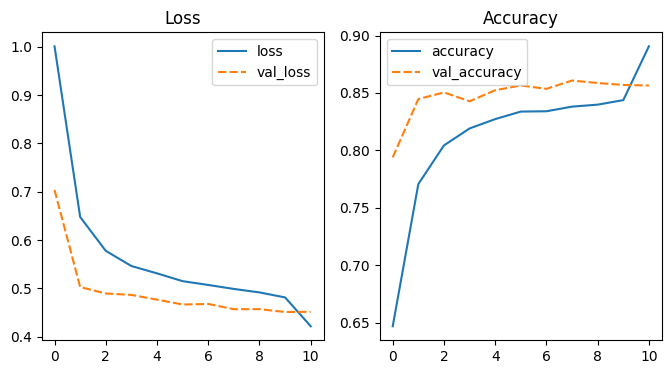

In [254]:
# Execute first 10 EPOCHS before main loop if PRE_EPOCH_RUN is True
if PRE_EPOCH_RUN:
  history = model.fit(trainX, trainY, 
                      epochs = epochs, 
                      batch_size = batch_size, 
                      validation_data=(valX,valY) if USE_VAL_BATCH_DATA else None,
                      validation_split=0.3 if not USE_VAL_BATCH_DATA else None,
                      callbacks=[model_checkpoint_callback, My_Callback()],
                      verbose=2,
                     )

if PRE_EPOCH_RUN: 
  hist_frame=pd.DataFrame(data=history.history)

  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)
  sns.lineplot(data=(hist_frame.loss, hist_frame.val_loss))
  plt.title('Loss')
  plt.subplot(1,2,2)
  sns.lineplot(data=(hist_frame.accuracy, hist_frame.val_accuracy))
  plt.title('Accuracy')

<div class="alert alert-block alert-info"><h3>
second epoch run - start from epoch 11 - then plot loss & accuracy
</h3></div>

Epoch 11/150
390/390 - 7s - loss: 0.4737 - accuracy: 0.8472 - val_loss: 0.4471 - val_accuracy: 0.8581 - 7s/epoch - 17ms/step
Epoch 12/150
390/390 - 8s - loss: 0.4702 - accuracy: 0.8468 - val_loss: 0.4439 - val_accuracy: 0.8584 - 8s/epoch - 20ms/step
Epoch 13/150
390/390 - 8s - loss: 0.4671 - accuracy: 0.8477 - val_loss: 0.4450 - val_accuracy: 0.8603 - 8s/epoch - 21ms/step
Epoch 14/150
390/390 - 9s - loss: 0.4623 - accuracy: 0.8483 - val_loss: 0.4414 - val_accuracy: 0.8603 - 9s/epoch - 22ms/step
Epoch 15/150
390/390 - 7s - loss: 0.4593 - accuracy: 0.8476 - val_loss: 0.4390 - val_accuracy: 0.8618 - 7s/epoch - 17ms/step
Epoch 16/150
390/390 - 6s - loss: 0.4555 - accuracy: 0.8500 - val_loss: 0.4349 - val_accuracy: 0.8644 - 6s/epoch - 16ms/step
Epoch 17/150
390/390 - 8s - loss: 0.4528 - accuracy: 0.8519 - val_loss: 0.4393 - val_accuracy: 0.8567 - 8s/epoch - 21ms/step
Epoch 18/150
390/390 - 11s - loss: 0.4506 - accuracy: 0.8516 - val_loss: 0.4308 - val_accuracy: 0.8627 - 11s/epoch - 28ms/ste

Text(0.5, 1.0, 'Accuracy')

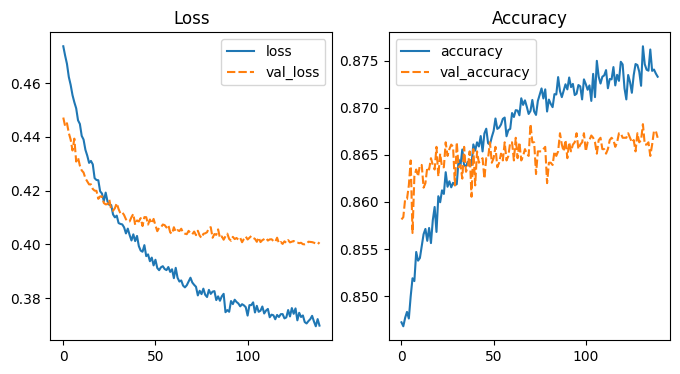

In [255]:
# mycallback = TerminateOnOne(monitor='accuracy', baseline=0.8)
# allbacks=[model_checkpoint_callback, early_stop, mycallback]

history = model.fit(trainX, trainY, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    validation_data=(valX,valY) if USE_VAL_BATCH_DATA else None,
                    validation_split=0.3 if not USE_VAL_BATCH_DATA else None,
                    callbacks=[model_checkpoint_callback, early_stop] if USE_EARLY_STOP else [model_checkpoint_callback],
                    initial_epoch=10 if PRE_EPOCH_RUN else None,
                    verbose=2,
                   )

hist_frame=pd.DataFrame(data=history.history)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.lineplot(data=(hist_frame.loss, hist_frame.val_loss))
plt.title('Loss')
plt.subplot(1,2,2)
sns.lineplot(data=(hist_frame.accuracy, hist_frame.val_accuracy))
plt.title('Accuracy')

<div class="alert alert-block alert-info"><h1>model evaluate (validation) and predict (hold-out)</h1></div>

130/130 [==============================] - 1s 4ms/step


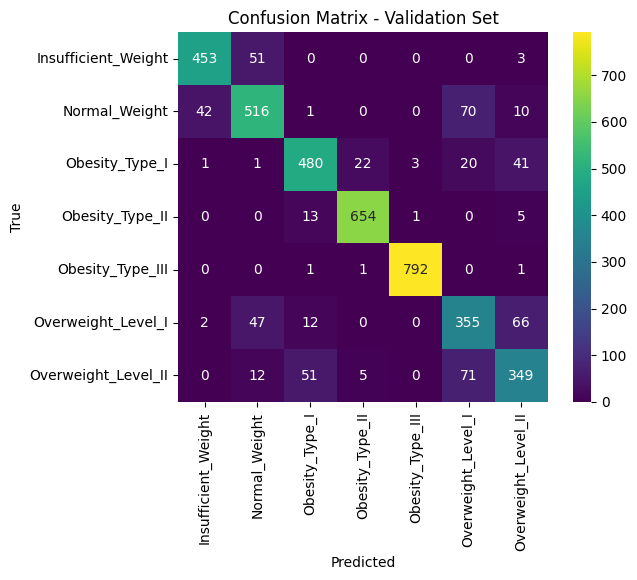

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       507
           1       0.82      0.81      0.82       639
           2       0.86      0.85      0.85       568
           3       0.96      0.97      0.97       673
           4       0.99      1.00      1.00       795
           5       0.69      0.74      0.71       482
           6       0.73      0.72      0.72       488

    accuracy                           0.87      4152
   macro avg       0.85      0.85      0.85      4152
weighted avg       0.87      0.87      0.87      4152

[[453  51   0   0   0   0   3]
 [ 42 516   1   0   0  70  10]
 [  1   1 480  22   3  20  41]
 [  0   0  13 654   1   0   5]
 [  0   0   1   1 792   0   1]
 [  2  47  12   0   0 355  66]
 [  0  12  51   5   0  71 349]]


In [256]:
## if USE_VAL_BATCH_DATA is false copy train -> val
if not USE_VAL_BATCH_DATA:
  valX = trainX.copy()
  valY = trainY.copy()

model.evaluate(valX, valY, batch_size=batch_size)

val_predictions = model.predict(valX)
v_predictions=[]
for i in range(len(val_predictions)):
  # print("Predicted=%s" % np.argmax(val_predictions[i]))
  v_predictions.append(np.argmax(val_predictions[i]))

# convert testY to true_labels
valY_actual=[]
for i in range(len(valY)):
  valY_actual.append(np.argmax(valY[i]))

unique_nums = np.unique([valY_actual, v_predictions])
unique_label = labelEnc.inverse_transform(unique_nums)
# from importlib import reload
# reload(plt)                       # reload since earlier I had plt.xlabel='PCA'
sns.heatmap(confusion_matrix(valY_actual, v_predictions), 
            annot=True, 
            cmap='viridis', 
            fmt='d', 
            xticklabels=unique_label,
            yticklabels=unique_label,
            square=True)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# classification report
print(classification_report(valY_actual, v_predictions))

# confusion_matrix
print(confusion_matrix(valY_actual, v_predictions))

<div class="alert alert-block alert-info"><h1>Predictions - Hold-Out set</h1></div>

130/130 [==============================] - 1s 6ms/step


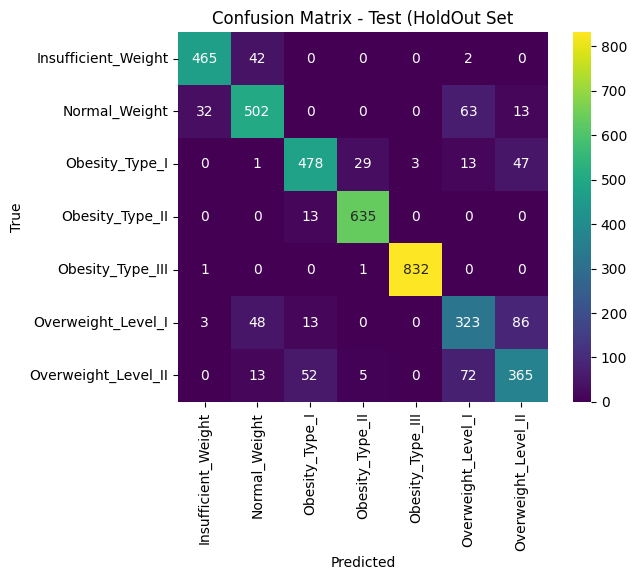

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       509
           1       0.83      0.82      0.83       610
           2       0.86      0.84      0.85       571
           3       0.95      0.98      0.96       648
           4       1.00      1.00      1.00       834
           5       0.68      0.68      0.68       473
           6       0.71      0.72      0.72       507

    accuracy                           0.87      4152
   macro avg       0.85      0.85      0.85      4152
weighted avg       0.87      0.87      0.87      4152

[[465  42   0   0   0   2   0]
 [ 32 502   0   0   0  63  13]
 [  0   1 478  29   3  13  47]
 [  0   0  13 635   0   0   0]
 [  1   0   0   1 832   0   0]
 [  3  48  13   0   0 323  86]
 [  0  13  52   5   0  72 365]]


In [257]:
if USE_TEST_SET:
  test_predictions = model.predict(testX)
  
  predictions=[]
  for i in range(len(test_predictions)):
    # print("Predicted=%s" % np.argmax(test_predictions[i]))
    predictions.append(np.argmax(test_predictions[i]))
  
  # convert testY to true_labels
  testY_actual=[]
  for i in range(len(testY)):
    testY_actual.append(np.argmax(testY[i]))
  
  unique_nums = np.unique([testY_actual, predictions])
  unique_label = labelEnc.inverse_transform(unique_nums)
  sns.heatmap(confusion_matrix(testY_actual, predictions), 
              xticklabels=unique_label, 
              yticklabels=unique_label,
              annot=True, 
              cmap='viridis', 
              fmt='d', 
              square=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix - Test (HoldOut Set')
  plt.show()
  
  # classification report
  print(classification_report(testY_actual, predictions))
  
  # confusion_matrix
  print(confusion_matrix(testY_actual, predictions))

<div class="alert alert-block alert-info"><h1>inference - Multi-Class Prediction (Obesity Risk)</h1></div>

In [258]:
# predictions_ = model.predict(X_test_cluster)
predictions_ = model.predict(X_test)

print(predictions_[:5])

predictions_max=[]
for i in range(len(predictions_)):
  predictions_max.append(np.argmax(predictions_[i]))

# Inverse label encoder
predictions_submit = labelEnc.inverse_transform(predictions_max)
print(predictions_submit[:5])

433/433 [==============================] - 2s 5ms/step
[[2.6984726e-05 1.0294210e-06 2.6407975e-04 9.9962556e-01 7.9558580e-05
  1.7412674e-06 1.0463783e-06]
 [1.6422402e-06 1.4282189e-02 9.4360989e-03 2.2555323e-06 2.2207021e-05
  9.5288545e-01 2.3370197e-02]
 [2.5749725e-06 7.7471206e-08 7.7757286e-06 9.3612095e-07 9.9998868e-01
  6.6633414e-09 3.2939973e-09]
 [2.3531396e-07 2.7118297e-11 9.8422235e-01 1.1207546e-02 2.0034531e-05
  1.1694902e-05 4.5381212e-03]
 [1.2451617e-05 3.4205984e-06 1.2941604e-03 7.8223266e-06 9.9868017e-01
  8.8772435e-07 1.0731433e-06]]
['Obesity_Type_II' 'Overweight_Level_I' 'Obesity_Type_III'
 'Obesity_Type_I' 'Obesity_Type_III']


In [259]:
curr = datetime.now()
curr = curr.strftime('%y_%m_%d_%H_%M_%S')
curr = f'Multi-Class Prediction (Obesity Risk) submitted:  {curr}'
print(curr)

Multi-Class Prediction (Obesity Risk) submitted:  24_03_07_06_28_19


In [260]:
# create DataFrame to write CSV file
# del predictions_data
predictions_data = pd.DataFrame(predictions_submit, columns=['NObeyesdad'])
predictions_data.insert(0, 'id', test_id)
hold_submission = f'submission_{curr}.csv'
predictions_data.to_csv(hold_submission, index = False)
predictions_data.to_csv('submission.csv', index = False)

predictions_data.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [261]:
!head -10 submission.csv

id,NObeyesdad
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
20763,Insufficient_Weight
20764,Insufficient_Weight
20765,Normal_Weight
20766,Overweight_Level_II


## end inference

<div class="alert alert-block alert-success">
<h4>submit your CSV file</h4>
<div>

In [262]:
# !kaggle competitions submit -c playground-series-s4e2 -f submission.csv -m curr

<block><pre>
@misc{playground-series-s4e2,
    author = {Walter Reade, Ashley Chow},
    title = {Multi-Class Prediction of Obesity Risk},
    publisher = {Kaggle},
    year = {2024},
    url = {https://kaggle.com/competitions/playground-series-s4e2}
}
</block></pre>

<block><pre>
@misc{omalley2019kerastuner,
    title        = {KerasTuner},
    author       = {O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others},
    year         = 2019,
    howpublished = {\url{https://github.com/keras-team/keras-tuner}}
}
</block></pre>